In [1]:
#####Evolving the parameters of the adaptive mechanism from Williams & Noble (2007)#####
#####and then examining the effect on the "region of viability" for a legged walker#####

import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
##create CTRNN

def sigmoid(x):
    return 1/(1+np.exp(-x))
def invsigmoid(x):
    return np.log(x/(1-x))

sigmoid(invsigmoid(.2))

0.2

In [24]:
class CTRNN():

    def __init__(self,size,dt,duration,slidingwindow,weights,biases,timeconsts):
        self.Size = size                                         # number of neurons in the circuit
        self.States = np.ones(size)                              # state of the neurons
        self.Outputs = np.zeros(size)                            # neuron outputs
        self.PlasticFacilitation = np.zeros(size)                #value of rho for each neuron to use in adaptive mech
        self.dt = dt                                             #size of walking timestep
        self.duration = duration                                 #duration in seconds
        self.time = np.arange(0.0,self.duration,dt)              #timeseries values in seconds
        self.ctrnn_record = np.zeros((size,len(self.time)))      #place to store data of the node firing rates over time
        self.Stepnum = 0                                         #initialize the step count at 0
        self.slidingwindow = slidingwindow                       #how far back to go in timesteps to calculate avg_firingrate (& avg_speed)
        self.max_firingrate = np.zeros(self.Size)                #keep track of the maximum firing rate (for diagnostic b/c place in the cycle varies it)
        self.min_firingrate = np.ones(self.Size)                 #keep track of the minimum firing rate (for diagnostic)
        self.Weights = np.copy(weights)
        self.Biases = np.copy(biases)
        self.invTimeConstants = 1.0/np.copy(timeconsts)
        self.bias_record = np.zeros((size,len(self.time)))       #since parameters of the system are changing under the adaptive mechanism, track them
        self.weight_record = np.zeros((size,size,len(self.time)))#not general, but okay for now
        self.Inputs = np.zeros((size))
             
    def resetStepcount(self):
        self.Stepnum = 0
        
    def setInputs(self,inputs): #external input to each neuron
        self.Inputs = inputs
    
    def setWeights(self, weights): #weight of connection for each neuron pair, going from row (i) to column (j)
        self.Weights = np.copy(weights)
        
    def randomizeWeights(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))

    def setBiases(self, biases): #bias shift for each neuron
        self.Biases =  np.copy(biases)
    
    def randomizeBiases(self):
        self.Biases = np.random.uniform(-10,10,size=(self.Size))

    def setTimeConstants(self, timeconstants): #time constant for each neuron
        self.TimeConstants =  np.copy(timeconstants)
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def randomizeTimeConstants(self):
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def setAdaptiveTimeConstants(self, adaptiveWtimeconstants, adaptiveBtimeconstants): #time constants for the adaptation of the weights & biases
        self.invadaptWTimeConsts = 1.0/np.copy(adaptiveWtimeconstants)
        self.invadaptBTimeConsts = 1.0/np.copy(adaptiveBtimeconstants)
        
    def randomizeAdaptiveTimeConstants(self):
        self.invadaptWTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        self.invadaptBTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        
    def setFacilitationFunctionParams(self,pLows,pHighs,pSlopes): #the parameters for the plastic facilitation function to determine rho
        self.pLows = pLows
        self.pHighs = pHighs
        self.pSlopes = pSlopes #always <0
        
    def randomizeFacilitationFunctionParams(self):
        self.pLows = np.random.uniform(.01,.49,self.Size)  #between .01 and .49 initially, although strictly only has to be lower than pHigh
        self.pHighs = np.random.uniform(.51,.99,self.Size) #between .51 and .99 initially, although strictly only has to be higher than pLow
        self.pSlopes = np.random.uniform(-10,0,self.Size)  #always <0

    def initializeState(self, s):
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)
        
    def plasticFacilitationCalc(self): #calculate and update the value of rho for each neuron, using the mean firing rate from the preceding segment of runtime
        for i in range(self.Size):
            if self.Stepnum < self.slidingwindow:
                self.PlasticFacilitation[i] = 0   #yet not enough data to evaluate average firing rate (don't want to use instantaneous firing rate bc it oscillates)
            else:
                avg_firingrate = np.mean(self.ctrnn_record[i,self.Stepnum-self.slidingwindow:self.Stepnum])
                if avg_firingrate > self.max_firingrate[i]:
                    self.max_firingrate[i] = avg_firingrate
                if avg_firingrate < self.min_firingrate[i]:
                    self.min_firingrate[i] = avg_firingrate
                #if self.Stepnum==self.slidingwindow or self.Stepnum == self.duration:
                    #print(avg_firingrate)
                if  avg_firingrate < self.pLows[i]:
                    self.PlasticFacilitation[i] = self.pSlopes[i]*(avg_firingrate - self.pLows[i] )
                elif avg_firingrate > self.pHighs[i]:
                    self.PlasticFacilitation[i] = self.pSlopes[i]*(avg_firingrate - self.pHighs[i])
                else:
                    self.PlasticFacilitation[i] = 0  #if in range, no change 
    
    def updateBiases(self): #use the value of rho for each neuron to dynamically change biases, scaling the change by 1/speed of walking
        for i in range(self.Size):
            self.Biases[i] += self.dt * self.invadaptBTimeConsts[i] * self.PlasticFacilitation[i]
            if self.Biases[i] >= 16:
                self.Biases[i] = 16
            if self.Biases[i] <= -16:
                self.Biases[i] = -16
    
    def updateWeights(self): #use the value of rho for each neuron to dynamically change all incoming weights to that neuron, scaling the change by 1/speed of walking
        for j in range(self.Size):
            incomingWeights = self.Weights[:,j]
            incomingWeights += self.dt * self.invadaptWTimeConsts[j] * self.PlasticFacilitation[j] * np.absolute(incomingWeights)
            self.Weights[:,j] = incomingWeights
            for i in range(self.Size):
                if self.Weights[i,j] >= 16:
                    self.Weights[i,j] = 16
                if self.Weights[i,j] <= -16:
                    self.Weights[i,j] = -16
        
    def ctrnnstep(self,adapt): #use the value of the weights and outputs to change the state of each neuron
        #if adapt = true, then we are implementing the adaptive mechanism
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += self.dt * (self.invTimeConstants*(-self.States+netinput))        
        self.Outputs = sigmoid(self.States+self.Biases)
        self.ctrnn_record[:,self.Stepnum] = self.Outputs
        if adapt == True:
            self.bias_record[:,self.Stepnum]=self.Biases
            self.weight_record[:,:,self.Stepnum]=self.Weights
            self.plasticFacilitationCalc()
            self.updateBiases()
            self.updateWeights()
        self.Stepnum += 1
        
    def plot(self):
        for i in range(self.Size):
            lab = "Neuron %d" %i
            plt.plot(self.time,self.ctrnn_record[i],label=lab)
        plt.title("Neural Activity")
        plt.xlabel("Time (s)")
        plt.ylabel("Firing Rate")
        plt.rcParams["figure.figsize"] = (20,3)
        plt.legend()
            

[[ 6.69593999  1.1443489  -6.51983932]
 [10.77771773  1.19328257  1.34273135]
 [16.          1.26584726  1.66087134]]
[-13.14805882  -1.54473649  -0.11657957]


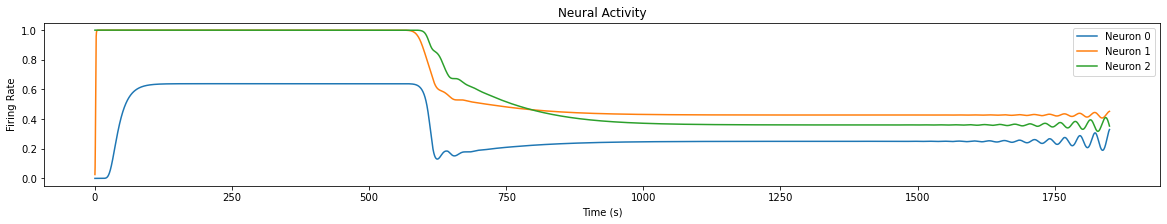

In [5]:
transient1 = 5000 #insteps
transient2 = 7000
testperiod = 500
duration = ((2*transient1)+transient2+(3*testperiod))/10
weights = np.array([[1.72785,3.7651,-1.20265],[2.78113,3.9261,7.3069],[12.543,4.16485,9.03816]])
biases = np.array([-15.8581,0.834461,3.26785])
timeconstants = np.array([9.42607,2.41159,7.85833])

C = CTRNN(3,0.1,duration,1,weights,biases,timeconstants)
C.setFacilitationFunctionParams(np.array([.25,.25,.25]),np.array([.75,.75,.75]),np.array([-4,-4,-4]))
C.setAdaptiveTimeConstants(np.array([40,40,40]),np.array([20,20,20]))
C.initializeState(invsigmoid(np.array([5.03977e-14,7.88983e-3,9.95847e-1])))
for i in range(transient1):
    C.ctrnnstep(0)
for i in range(testperiod):
    C.ctrnnstep(0)
for i in range(transient2):
    C.ctrnnstep(1)
for i in range(testperiod):
    C.ctrnnstep(1)
for i in range(transient1):
    C.ctrnnstep(0)
for i in range(testperiod):
    C.ctrnnstep(0)
    
C.plot()
print(C.Weights)
print(C.Biases)

incomingweights to  0 :  [ 6.60946 10.6385  16.     ]
incomingweights to  1 :  [1.14559 1.19458 1.26722]
incomingweights to  2 :  [-6.51152  1.34445  1.663  ]
incomingweights to  0 :  [ 6.60946 10.6385  16.     ]
incomingweights to  1 :  [1.14559 1.19458 1.26722]
incomingweights to  2 :  [-6.51152  1.34445  1.663  ]
incomingweights to  0 :  [ 6.62598365 10.66509625 16.        ]
incomingweights to  1 :  [1.14842894 1.19754035 1.27036036]
incomingweights to  2 :  [-6.52748084  1.34115452  1.6589237 ]
incomingweights to  0 :  [ 6.64254861 10.69175899 16.        ]
incomingweights to  1 :  [1.15126806 1.20050088 1.27350091]
incomingweights to  2 :  [-6.54346521  1.33787033  1.65486137]
incomingweights to  0 :  [ 6.65915498 10.71848839 16.        ]
incomingweights to  1 :  [1.15410564 1.20345981 1.27663977]
incomingweights to  2 :  [-6.5594708   1.33459784  1.6508135 ]
incomingweights to  0 :  [ 6.67580287 10.74528461 16.        ]
incomingweights to  1 :  [1.15693985 1.20641521 1.27977489]
i

incomingweights to  0 :  [ 8.29553824 13.35238938 16.        ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.92381538  1.10434924  1.36601048]
incomingweights to  0 :  [ 8.31627652 13.38576945 16.        ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.9373156   1.10246771  1.36368314]
incomingweights to  0 :  [ 8.33706649 13.41923272 16.        ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.9507402   1.10060307  1.3613767 ]
incomingweights to  0 :  [ 8.35790825 13.45277934 16.        ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.96408833  1.09875532  1.35909115]
incomingweights to  0 :  [ 8.37880188 13.48640945 16.        ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.97735913  1.09692443  1.35682646]
incomingweights to  0 :  [ 8.39974745 13.52012316 16.        ]
incomin

incomingweights to  0 :  [ 9.38789288 15.11062907 15.90343905]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-8.58784902  1.01885039  1.26025378]
incomingweights to  0 :  [ 9.37343534 15.08735841 15.87894745]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-8.58784902  1.01885039  1.26025378]
incomingweights to  0 :  [ 9.35796938 15.06246459 15.85274753]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-8.58784902  1.01885039  1.26025378]
incomingweights to  0 :  [ 9.34163669 15.03617572 15.82507936]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-8.58784902  1.01885039  1.26025378]
incomingweights to  0 :  [ 9.324561   15.00869091 15.7961525 ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-8.58784902  1.01885039  1.26025378]
incomingweights to  0 :  [ 9.30684961 14.98018289 15.76614875]
incomin

incomingweights to  0 :  [ 7.64835804 12.31069664 12.95660246]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.41223529  1.18007216  1.45967496]
incomingweights to  0 :  [ 7.63015765 12.28140153 12.92577032]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.39424178  1.18293683  1.46321838]
incomingweights to  0 :  [ 7.61201801 12.25220421 12.8950411 ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.37628126  1.18581017  1.46677252]
incomingweights to  0 :  [ 7.59393956 12.22310537 12.86441554]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.35835421  1.18869212  1.47033731]
incomingweights to  0 :  [ 7.57592274 12.19410573 12.83389437]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-7.34046108  1.19158263  1.47391269]
incomingweights to  0 :  [ 7.557968   12.16520602 12.80347838]
incomin

incomingweights to  2 :  [-6.13807824  1.4243777   1.76186553]
incomingweights to  0 :  [ 6.47850841 10.42772204 10.97483375]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-6.12308625  1.42785668  1.76616881]
incomingweights to  0 :  [ 6.46850713 10.41162412 10.95789122]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-6.10813487  1.43134323  1.77048145]
incomingweights to  0 :  [ 6.45870973 10.39585435 10.94129406]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-6.09322414  1.43483732  1.77480342]
incomingweights to  0 :  [ 6.44912094 10.38042035 10.92505028]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-6.07835412  1.43833892  1.77913468]
incomingweights to  0 :  [ 6.43974559 10.36532992 10.9091681 ]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-6.06352485  1.44184801  1.78347521]
incomin

incomingweights to  2 :  [-5.15177539  1.69637094  2.09830405]
incomingweights to  0 :  [ 6.28698071 10.11944157 10.65037872]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-5.14068946  1.7000213   2.10281931]
incomingweights to  0 :  [ 6.28698071 10.11944157 10.65037872]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-5.12969723  1.70365642  2.10731573]
incomingweights to  0 :  [ 6.28698071 10.11944157 10.65037872]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-5.11880142  1.7072751   2.1117918 ]
incomingweights to  0 :  [ 6.28698071 10.11944157 10.65037872]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-5.10800487  1.71087607  2.11624598]
incomingweights to  0 :  [ 6.28698071 10.11944157 10.65037872]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-5.09731053  1.71445804  2.12067665]
incomin

incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78053024  1.82788341  2.26097669]
incomingweights to  0 :  [ 7.14666899 11.50318453 12.10672258]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78053024  1.82788341  2.26097669]
incomingweights to  0 :  [ 7.16226567 11.52828875 12.13314394]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78053024  1.82788341  2.26097669]
incomingweights to  0 :  [ 7.17786951 11.55340448 12.15957742]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78053024  1.82788341  2.26097669]
incomingweights to  0 :  [ 7.19347712 11.57852628 12.18601729]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78053024  1.82788341  2.26097669]
incomingweights to  0 :  [ 7.20908497 11.60364848 12.21245758]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingwe

incomingweights to  2 :  [-4.78152477  1.8275032   2.26050639]
incomingweights to  0 :  [ 7.79248467 12.54268097 13.20075832]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78186514  1.82737311  2.26034548]
incomingweights to  0 :  [ 7.79248467 12.54268097 13.20075832]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78222928  1.82723395  2.26017335]
incomingweights to  0 :  [ 7.79248467 12.54268097 13.20075832]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78260673  1.82708973  2.25999496]
incomingweights to  0 :  [ 7.79248467 12.54268097 13.20075832]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78298685  1.82694452  2.25981534]
incomingweights to  0 :  [ 7.79248467 12.54268097 13.20075832]
incomingweights to  1 :  [1.2232235  1.27553342 1.35309603]
incomingweights to  2 :  [-4.78335881  1.82680244  2.2596396 ]
incomin

incomingweights to  1 :  [1.20760003 1.25924183 1.33581378]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 7.0877663  11.40837553 12.00693923]
incomingweights to  1 :  [1.20693131 1.25854451 1.33507407]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 7.0704772  11.38054723 11.97765086]
incomingweights to  1 :  [1.20626351 1.25784815 1.33433536]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 7.05321457 11.35276153 11.94840733]
incomingweights to  1 :  [1.20559733 1.25715349 1.33359845]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 7.03597967 11.32502045 11.91921076]
incomingweights to  1 :  [1.20493348 1.25646124 1.33286412]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 7.01877362 11.29732583 11.89006308]
incomingweights to  1 :  [1.20427261 1.25577211 1.33213308]
incomingwe

incomingweights to  0 :  [ 6.2675664  10.08819256 10.61749016]
incomingweights to  1 :  [1.18421271 1.23485437 1.30994337]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 6.25221342 10.0634806  10.59148165]
incomingweights to  1 :  [1.18408509 1.23472129 1.3098022 ]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 6.23690542 10.03884103 10.56554931]
incomingweights to  1 :  [1.18397185 1.23460321 1.30967694]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 6.22164265 10.01427428 10.53969361]
incomingweights to  1 :  [1.18387296 1.23450009 1.30956755]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 6.20642539  9.98978079 10.51391502]
incomingweights to  1 :  [1.18378837 1.23441189 1.30947399]
incomingweights to  2 :  [-4.78479852  1.82625274  2.25895965]
incomingweights to  0 :  [ 6.19125395  9.96536104 10.48821404]
incomin

incomingweights to  0 :  [5.37191048 8.64655654 9.10021577]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.62293878  1.89014745  2.33799339]
incomingweights to  0 :  [5.36173441 8.63017728 9.08297714]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.61856941  1.89193392  2.34020314]
incomingweights to  0 :  [5.35171828 8.61405545 9.06600945]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.61418347  1.89373056  2.34242547]
incomingweights to  0 :  [5.34186705 8.59819904 9.04932109]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.60978268  1.89553672  2.34465957]
incomingweights to  0 :  [5.33218584 8.58261629 9.03292077]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.60536875  1.89735172  2.34690461]
incomingweights to  0 :  [5.32267995 8.56731573 9.01681743]
incomingweights to  1 :  

incomingweights to  2 :  [-4.39622649  1.9875364   2.45845739]
incomingweights to  0 :  [5.1508767  8.29078347 8.72577634]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39497097  1.98810402  2.4591595 ]
incomingweights to  0 :  [5.1508767  8.29078347 8.72577634]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39386447  1.98860456  2.45977863]
incomingweights to  0 :  [5.1508767  8.29078347 8.72577634]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39291144  1.98903589  2.46031216]
incomingweights to  0 :  [5.1508767  8.29078347 8.72577634]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39211637  1.98939588  2.46075745]
incomingweights to  0 :  [5.1508767  8.29078347 8.72577634]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.3914838   1.9896824   2.46111185]
incomingweights to  0 

incomingweights to  2 :  [-4.39061428  1.99007641  2.46159922]
incomingweights to  0 :  [5.55383241 8.9393757  9.40839828]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39082956  1.98997883  2.46147852]
incomingweights to  0 :  [5.56158819 8.95185931 9.42153687]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39124844  1.98978899  2.4612437 ]
incomingweights to  0 :  [5.56927634 8.96423405 9.43456088]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39186593  1.98950919  2.4608976 ]
incomingweights to  0 :  [5.5768915  8.9764913  9.44746123]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39267713  1.98914171  2.46044306]
incomingweights to  0 :  [5.5844282  8.98862228 9.46022869]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.39367719  1.98868886  2.4598829 ]
incomingweights to  0 

incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.73908898  1.84359277  2.28040818]
incomingweights to  0 :  [5.74672223 9.24984862 9.7351608 ]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.74392458  1.84171163  2.27808133]
incomingweights to  0 :  [5.74672223 9.24984862 9.7351608 ]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.74867429  1.83986767  2.27580047]
incomingweights to  0 :  [5.74672223 9.24984862 9.7351608 ]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.75333354  1.83806245  2.27356752]
incomingweights to  0 :  [5.74672223 9.24984862 9.7351608 ]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  [-4.75789772  1.83629753  2.27138443]
incomingweights to  0 :  [5.74672223 9.24984862 9.7351608 ]
incomingweights to  1 :  [1.18357835 1.23419288 1.30924166]
incomingweights to  2 :  

incomingweights to  1 :  [1.15114818 1.20037587 1.27336831]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.14449815 8.28051665 8.71497085]
incomingweights to  1 :  [1.15079271 1.2000052  1.2729751 ]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.13474355 8.26481577 8.69844619]
incomingweights to  1 :  [1.15045061 1.19964847 1.27259667]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.12504371 8.24920304 8.68201431]
incomingweights to  1 :  [1.15012212 1.19930593 1.27223331]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.11540116 8.23368252 8.66567947]
incomingweights to  1 :  [1.14980749 1.19897784 1.27188527]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.10581846 8.21825833 8.64944602]
incomingweights to  1 :  [1.14950693 1.19866443 1.2715528 ]
incomingweights to  2 :  

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [4.77772912 7.69017003 8.09365049]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [4.77772912 7.69017003 8.09365049]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [4.77772912 7.69017003 8.09365049]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [4.77772912 7.69017003 8.09365049]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [4.77772912 7.69017003 8.09365049]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  

incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.18694601 8.34884016 8.7868791 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.19620366 8.36374115 8.80256189]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.20547235 8.37865992 8.81826341]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.21474966 8.39359256 8.83397952]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 :  [5.22403314 8.40853512 8.84970607]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.82865214  1.80937224  2.23807954]
incomingweights to  0 

incomingweights to  2 :  [-5.15540291  1.69458546  2.09609552]
incomingweights to  0 :  [5.69279592 9.16304954 9.64380763]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.16121996  1.69267339  2.09373041]
incomingweights to  0 :  [5.69279592 9.16304954 9.64380763]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.16701382  1.69077324  2.09138004]
incomingweights to  0 :  [5.69279592 9.16304954 9.64380763]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.17278158  1.68888589  2.0890455 ]
incomingweights to  0 :  [5.69279592 9.16304954 9.64380763]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.17852026  1.68701224  2.08672792]
incomingweights to  0 :  [5.69279592 9.16304954 9.64380763]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.18422683  1.6851532   2.08442841]
incomingweights to  0 

incomingweights to  0 :  [5.60548214 9.02251042 9.49589484]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.34269706  1.63512852  2.02255102]
incomingweights to  0 :  [5.59979167 9.01335111 9.48625497]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.34269706  1.63512852  2.02255102]
incomingweights to  0 :  [5.59401523 9.00405344 9.47646947]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.34269706  1.63512852  2.02255102]
incomingweights to  0 :  [5.58816063 8.99462996 9.46655157]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.34269706  1.63512852  2.02255102]
incomingweights to  0 :  [5.58223549 8.98509292 9.45651415]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.34269706  1.63512852  2.02255102]
incomingweights to  0 :  [5.57624723 8.9754543  9.44636982]
incomingweights to  1 :  

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32760566  1.63975937  2.0282791 ]
incomingweights to  0 :  [5.33250861 8.58313582 9.03346755]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32612619  1.64021473  2.02884235]
incomingweights to  0 :  [5.33250861 8.58313582 9.03346755]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32461645  1.64067967  2.02941745]
incomingweights to  0 :  [5.33250861 8.58313582 9.03346755]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32308202  1.64115247  2.03000228]
incomingweights to  0 :  [5.33250861 8.58313582 9.03346755]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.3215285   1.64163143  2.03059472]
incomingweights to  0 :  [5.33250861 8.58313582 9.03346755]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.29304133  1.65046453  2.04152071]
incomingweights to  0 :  [5.68531258 9.15100446 9.63113058]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.29304133  1.65046453  2.04152071]
incomingweights to  0 :  [5.69616143 9.16846661 9.64950892]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.29304133  1.65046453  2.04152071]
incomingweights to  0 :  [5.70707142 9.1860272  9.66799086]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.29304133  1.65046453  2.04152071]
incomingweights to  0 :  [5.71803962 9.20368146 9.68657139]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.29304133  1.65046453  2.04152071]
incomingweights to  0 :  [5.72906315 9.22142479 9.70524566]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.49190144 10.44927928 10.99752204]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.31977277  1.64216885  2.03125948]
incomingweights to  0 :  [ 6.4946391  10.45368579 11.00215975]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32173669  1.64156261  2.03050959]
incomingweights to  0 :  [ 6.49694542 10.45739801 11.00606674]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32373416  1.64094646  2.02974745]
incomingweights to  0 :  [ 6.49880659 10.46039373 11.00921963]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.32576091  1.64032175  2.02897473]
incomingweights to  0 :  [ 6.50020882 10.46265074 11.01159506]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.3278126   1.63968983  2.02819308]
incomingweights to  0 :  [ 6.50113836 10.4641469  11.01316972]
incomin

incomingweights to  0 :  [ 6.27457301 10.09947029 10.62935961]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.37603651  1.62497666  2.00999382]
incomingweights to  0 :  [ 6.26410949 10.08262835 10.61163402]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.37603651  1.62497666  2.00999382]
incomingweights to  0 :  [ 6.25357958 10.06567956 10.59379597]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.37603651  1.62497666  2.00999382]
incomingweights to  0 :  [ 6.24299097 10.04863626 10.57585846]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.37603651  1.62497666  2.00999382]
incomingweights to  0 :  [ 6.23235097 10.03151026 10.55783391]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.37603651  1.62497666  2.00999382]
incomingweights to  0 :  [ 6.2216666  10.01431283 10.53973419]
incomin

incomingweights to  2 :  [-5.13923954  1.69977965  2.1025204 ]
incomingweights to  0 :  [5.66300389 9.11509668 9.59333883]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.13364166  1.70163112  2.10481056]
incomingweights to  0 :  [5.66300389 9.11509668 9.59333883]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.12807043  1.7034778   2.10709478]
incomingweights to  0 :  [5.66300389 9.11509668 9.59333883]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.12252954  1.70531841  2.1093715 ]
incomingweights to  0 :  [5.66300389 9.11509668 9.59333883]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.11702267  1.70715168  2.11163914]
incomingweights to  0 :  [5.66300389 9.11509668 9.59333883]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.11155357  1.70897629  2.11389607]
incomingweights to  0 

incomingweights to  0 :  [5.87384623 9.45446573 9.95051357]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97217036  1.75684386  2.17310524]
incomingweights to  0 :  [5.88395961 9.4707441  9.96764601]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97217036  1.75684386  2.17310524]
incomingweights to  0 :  [5.89419599 9.48722044 9.98498682]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97217036  1.75684386  2.17310524]
incomingweights to  0 :  [ 5.90454977  9.50388575 10.0025265 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97217036  1.75684386  2.17310524]
incomingweights to  0 :  [ 5.91501555  9.52073134 10.02025593]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97217036  1.75684386  2.17310524]
incomingweights to  0 :  [ 5.92558816  9.53774888 10.03816633]
incomingweights 

incomingweights to  0 :  [ 6.74244365 10.85254874 11.42194986]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.9878862   1.75130703  2.16625653]
incomingweights to  0 :  [ 6.74455302 10.85594394 11.42552319]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.98964304  1.75069019  2.16549353]
incomingweights to  0 :  [ 6.74613245 10.85848618 11.42819882]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.9914631   1.75005159  2.16470363]
incomingweights to  0 :  [ 6.74716281 10.86014464 11.42994429]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.99334155  1.74939299  2.16388898]
incomingweights to  0 :  [ 6.74762491 10.86088843 11.4307271 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.99527353  1.74871613  2.16305175]
incomingweights to  0 :  [ 6.74762491 10.86088843 11.4307271 ]
incomin

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.05200991  1.72906992  2.13875062]
incomingweights to  0 :  [ 6.38638387 10.27943958 10.81877136]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.05200991  1.72906992  2.13875062]
incomingweights to  0 :  [ 6.37315396 10.2581449  10.7963594 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.05200991  1.72906992  2.13875062]
incomingweights to  0 :  [ 6.35988743 10.23679127 10.77388541]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.05200991  1.72906992  2.13875062]
incomingweights to  0 :  [ 6.34658957 10.2153872  10.75135834]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-5.05200991  1.72906992  2.13875062]
incomingweights to  0 :  [ 6.33326535 10.19394072 10.72878662]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingwe

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.95764812  1.76195929  2.17943271]
incomingweights to  0 :  [5.43842562 8.75361845 9.2128949 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.95337726  1.76347716  2.18131022]
incomingweights to  0 :  [5.43295276 8.74480939 9.20362366]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.94906242  1.76501331  2.18321034]
incomingweights to  0 :  [5.42776156 8.73645372 9.19482959]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.94470689  1.76656665  2.18513172]
incomingweights to  0 :  [5.42286013 8.72856444 9.18652638]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.94031394  1.76813609  2.18707302]
incomingweights to  0 :  [5.4182567  8.72115481 9.17872799]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  

incomingweights to  2 :  [-4.73925523  1.84308607  2.27978143]
incomingweights to  0 :  [5.5219071  8.88798913 9.35431562]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.73925523  1.84308607  2.27978143]
incomingweights to  0 :  [5.53032333 8.90153579 9.36857303]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.73925523  1.84308607  2.27978143]
incomingweights to  0 :  [5.53889579 8.91533391 9.3830951 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.73925523  1.84308607  2.27978143]
incomingweights to  0 :  [5.54761733 8.92937198 9.3978697 ]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.73925523  1.84308607  2.27978143]
incomingweights to  0 :  [5.55648107 8.94363895 9.41288522]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.73925523  1.84308607  2.27978143]
incomingweights to  0 

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.76172001  1.83438767  2.26902205]
incomingweights to  0 :  [ 6.28183661 10.11116169 10.64166442]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.76423359  1.83341935  2.2678243 ]
incomingweights to  0 :  [ 6.28842969 10.12177383 10.65283334]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.76685486  1.83241061  2.26657655]
incomingweights to  0 :  [ 6.29474852 10.13194454 10.66353768]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.76958006  1.83136302  2.26528075]
incomingweights to  0 :  [ 6.30078103 10.14165439 10.67375698]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.77240546  1.83027816  2.26393885]
incomingweights to  0 :  [ 6.30651484 10.15088345 10.68347026]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingwe

incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97202884  1.75674169  2.17297886]
incomingweights to  0 :  [ 6.11386664  9.84079944 10.35711706]
incomingweights to  1 :  [1.14672384 1.19576233 1.26847422]
incomingweights to  2 :  [-4.97202884  1.75674169  2.17297886]
incomingweights to  0 :  [ 6.1023911   9.82232856 10.33767707]
incomingweights to  1 :  [1.14671868 1.19575695 1.26846852]
incomingweights to  2 :  [-4.97202884  1.75674169  2.17297886]
incomingweights to  0 :  [ 6.09082288  9.8037085  10.31808007]
incomingweights to  1 :  [1.14670408 1.19574173 1.26845237]
incomingweights to  2 :  [-4.97202884  1.75674169  2.17297886]
incomingweights to  0 :  [ 6.07917012  9.78495238 10.29833987]
incomingweights to  1 :  [1.14668089 1.19571755 1.26842672]
incomingweights to  2 :  [-4.97202884  1.75674169  2.17297886]
incomingweights to  0 :  [ 6.06744049  9.76607251 10.27846943]
incomingweights to  1 :  [1.14664997 1.1956853  1.26839251]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96556006  1.75902985  2.17580917]
incomingweights to  0 :  [5.23178759 8.42101658 8.86284239]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96425081  1.75949365  2.17638286]
incomingweights to  0 :  [5.22545896 8.41083011 8.85212147]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96283752  1.75999456  2.17700246]
incomingweights to  0 :  [5.21936216 8.40101678 8.84179327]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96132429  1.76053121  2.17766626]
incomingweights to  0 :  [5.21350445 8.39158828 8.83187008]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95971519  1.7611022   2.17837254]
incomingweights to  0 :  [5.20789325 8.38255658 8.82236451]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.84453618  1.80295285  2.23013916]
incomingweights to  0 :  [5.20942385 8.3850202  8.82495739]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.84453618  1.80295285  2.23013916]
incomingweights to  0 :  [5.21538798 8.39461998 8.83506085]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.84453618  1.80295285  2.23013916]
incomingweights to  0 :  [5.22160189 8.40462181 8.84558744]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.84453618  1.80295285  2.23013916]
incomingweights to  0 :  [5.22805491 8.41500851 8.8565191 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.84453618  1.80295285  2.23013916]
incomingweights to  0 :  [5.23473676 8.42576353 8.86783841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.84453618  1.80295285  2.23013916]
incomingweights to  0 

incomingweights to  0 :  [ 6.09749298  9.81444461 10.32937947]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88845724  1.78674633  2.21009271]
incomingweights to  0 :  [ 6.10468953  9.82602809 10.3415707 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89177119  1.78553507  2.20859446]
incomingweights to  0 :  [ 6.11165986  9.83724743 10.35337869]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89517448  1.78429284  2.2070579 ]
incomingweights to  0 :  [ 6.11839425  9.84808703 10.36478701]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8986639   1.78302095  2.20548465]
incomingweights to  0 :  [ 6.12488278  9.85853088 10.37577882]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90223625  1.78172068  2.2038763 ]
incomingweights to  0 :  [ 6.13111526  9.86856259 10.38633686]
incomin

incomingweights to  2 :  [-5.13653473  1.70038596  2.10327037]
incomingweights to  0 :  [ 6.09998393  9.81845401 10.33359923]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.13653473  1.70038596  2.10327037]
incomingweights to  0 :  [ 6.09178525  9.80525752 10.31971036]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.13653473  1.70038596  2.10327037]
incomingweights to  0 :  [ 6.08335306  9.79168518 10.30542593]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.13653473  1.70038596  2.10327037]
incomingweights to  0 :  [ 6.07470224  9.77776093 10.29077111]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.13653473  1.70038596  2.10327037]
incomingweights to  0 :  [ 6.06584699  9.76350763 10.27576998]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.13653473  1.70038596  2.10327037]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12857122  1.70302574  2.10653562]
incomingweights to  0 :  [5.32269195 8.56733505 9.01683777]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12699758  1.7035483   2.10718198]
incomingweights to  0 :  [5.31733631 8.55871467 9.0077651 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12530225  1.7041116   2.10787876]
incomingweights to  0 :  [5.31222426 8.55048639 8.99910511]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12349007  1.70471413  2.10862405]
incomingweights to  0 :  [5.30736337 8.54266236 8.99087057]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12156585  1.70535437  2.10941598]
incomingweights to  0 :  [5.30276132 8.53525497 8.98307453]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [5.40403093 8.69825721 9.15462902]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97558315  1.75536182  2.17127205]
incomingweights to  0 :  [5.4125275  8.71193318 9.16902252]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97558315  1.75536182  2.17127205]
incomingweights to  0 :  [5.42118367 8.72586603 9.18368639]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97558315  1.75536182  2.17127205]
incomingweights to  0 :  [5.42999245 8.74004453 9.1986088 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97558315  1.75536182  2.17127205]
incomingweights to  0 :  [5.43894717 8.75445792 9.21377842]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97558315  1.75536182  2.17127205]
incomingweights to  0 :  [5.44804141 8.7690959  9.22918441]
incomingweights to  1 :  

incomingweights to  2 :  [-4.99084939  1.74999096  2.16462863]
incomingweights to  0 :  [ 6.2603628  10.07659773 10.60528699]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99289954  1.7492721   2.16373944]
incomingweights to  0 :  [ 6.26846522 10.08963929 10.6190128 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99505806  1.74851585  2.16280402]
incomingweights to  0 :  [ 6.27635024 10.10233091 10.63237031]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99732139  1.74772358  2.16182402]
incomingweights to  0 :  [ 6.28400774 10.11465632 10.6453424 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99968594  1.74689662  2.16080112]
incomingweights to  0 :  [ 6.2914273  10.12659875 10.65791141]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00214817  1.74603631  2.15973698]
incomin

incomingweights to  0 :  [ 6.28858699 10.12202702 10.65309983]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.17658024  1.68716498  2.08691686]
incomingweights to  0 :  [ 6.28013635 10.10842498 10.63878412]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.17658024  1.68716498  2.08691686]
incomingweights to  0 :  [ 6.27142059 10.0943962  10.62401929]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.17658024  1.68716498  2.08691686]
incomingweights to  0 :  [ 6.26245695 10.07996845 10.60883457]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.17658024  1.68716498  2.08691686]
incomingweights to  0 :  [ 6.25326188 10.06516819 10.59325777]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.17658024  1.68716498  2.08691686]
incomingweights to  0 :  [ 6.24385101 10.05002058 10.57731541]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.15053929  1.69569206  2.09746432]
incomingweights to  0 :  [5.45017577 8.77253133 9.23280009]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.14774949  1.69661054  2.09860041]
incomingweights to  0 :  [5.44401673 8.76261783 9.22236645]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.14485052  1.69756599  2.09978224]
incomingweights to  0 :  [5.43809148 8.75308062 9.21232885]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.141847    1.69855701  2.10100808]
incomingweights to  0 :  [5.43240728 8.7439314  9.2026996 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.13874351  1.69958222  2.1022762 ]
incomingweights to  0 :  [5.42697154 8.73518211 9.19349126]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.92587206  1.77297593  2.1930596 ]
incomingweights to  0 :  [5.43783224 8.75266335 9.21188969]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92587206  1.77297593  2.1930596 ]
incomingweights to  0 :  [5.44427552 8.76303437 9.22280485]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92587206  1.77297593  2.1930596 ]
incomingweights to  0 :  [5.45097749 8.77382176 9.23415822]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92587206  1.77297593  2.1930596 ]
incomingweights to  0 :  [5.45792711 8.78500779 9.24593115]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92587206  1.77297593  2.1930596 ]
incomingweights to  0 :  [5.46511378 8.79657535 9.25810563]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92587206  1.77297593  2.1930596 ]
incomingweights to  0 

incomingweights to  0 :  [ 6.34814416 10.21788945 10.75399187]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93482096  1.76976009  2.1890818 ]
incomingweights to  0 :  [ 6.35647065 10.23129166 10.76809725]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93644793  1.76917661  2.18836008]
incomingweights to  0 :  [ 6.36457676 10.24433915 10.7818293 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93819347  1.76855103  2.18758627]
incomingweights to  0 :  [ 6.37245178 10.25701468 10.79516988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94005374  1.76788479  2.18676218]
incomingweights to  0 :  [ 6.38008466 10.26930046 10.80810026]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9420249   1.76717938  2.18588963]
incomingweights to  0 :  [ 6.38746399 10.28117814 10.82060112]
incomin

incomingweights to  0 :  [ 6.3446275  10.21222908 10.74803452]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10291103  1.711431    2.11693239]
incomingweights to  0 :  [ 6.33480954 10.19642622 10.73140253]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10291103  1.711431    2.11693239]
incomingweights to  0 :  [ 6.324769   10.18026511 10.71439349]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10291103  1.711431    2.11693239]
incomingweights to  0 :  [ 6.31452169 10.16377117 10.69703416]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10291103  1.711431    2.11693239]
incomingweights to  0 :  [ 6.30408253 10.14696844 10.67934984]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10291103  1.711431    2.11693239]
incomingweights to  0 :  [ 6.29346566 10.12987966 10.66136446]
incomin

incomingweights to  0 :  [5.44503693 8.76425992 9.2240947 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08189566  1.71850599  2.12568371]
incomingweights to  0 :  [5.43755253 8.75221313 9.21141585]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07940259  1.71934905  2.12672652]
incomingweights to  0 :  [5.43027067 8.74049235 9.19908011]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07679781  1.72023076  2.12781714]
incomingweights to  0 :  [5.42319784 8.72910801 9.18709847]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07408564  1.72114975  2.12895387]
incomingweights to  0 :  [5.41634067 8.71807079 9.17548217]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07127041  1.72210469  2.13013507]
incomingweights to  0 :  [5.40970597 8.70739168 9.16424275]
incomingweights to  1 :  

incomingweights to  0 :  [5.44255986 8.76027286 9.21989845]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.85963203  1.79704936  2.22283691]
incomingweights to  0 :  [5.45050297 8.77305799 9.23335438]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.85963203  1.79704936  2.22283691]
incomingweights to  0 :  [5.4586314  8.78614141 9.24712424]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.85963203  1.79704936  2.22283691]
incomingweights to  0 :  [5.46693694 8.79950989 9.26119413]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.85963203  1.79704936  2.22283691]
incomingweights to  0 :  [5.47541172 8.81315078 9.27555072]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.85963203  1.79704936  2.22283691]
incomingweights to  0 :  [5.48404821 8.82705196 9.29018125]
incomingweights to  1 :  

incomingweights to  2 :  [-4.87939907  1.78976694  2.21382902]
incomingweights to  0 :  [ 6.29694145 10.13547425 10.66725259]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88173129  1.78891148  2.21277087]
incomingweights to  0 :  [ 6.30426512 10.14726234 10.67965916]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88416978  1.7880179   2.21166556]
incomingweights to  0 :  [ 6.31133533 10.15864244 10.69163635]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88671083  1.78708765  2.21051491]
incomingweights to  0 :  [ 6.3181406  10.16959613 10.70316474]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8893508   1.78612221  2.20932072]
incomingweights to  0 :  [ 6.32466918 10.18010443 10.71422438]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89208601  1.78512302  2.20808477]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07368975  1.72118546  2.12899804]
incomingweights to  0 :  [ 6.1995268   9.9786769  10.50222854]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07368975  1.72118546  2.12899804]
incomingweights to  0 :  [ 6.18874198  9.9613178  10.48395866]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07368975  1.72118546  2.12899804]
incomingweights to  0 :  [ 6.1778236   9.94374372 10.46546253]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07368975  1.72118546  2.12899804]
incomingweights to  0 :  [ 6.16678226  9.92597173 10.44675809]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07368975  1.72118546  2.12899804]
incomingweights to  0 :  [ 6.15562795  9.9080179  10.42786228]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04932435  1.72948816  2.13926796]
incomingweights to  0 :  [5.33145274 8.58143629 9.03167886]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04681501  1.73034766  2.1403311 ]
incomingweights to  0 :  [5.32577296 8.57229421 9.02205711]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04421325  1.73123969  2.1414345 ]
incomingweights to  0 :  [5.32034673 8.56356021 9.01286487]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04152331  1.73216292  2.14257647]
incomingweights to  0 :  [5.31518175 8.55524673 9.0041152 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03874941  1.73311597  2.14375534]
incomingweights to  0 :  [5.3102859  8.54736644 8.99582146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.87620487  1.79085164  2.21517072]
incomingweights to  0 :  [5.33675699 8.58997395 9.04066446]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.87620487  1.79085164  2.21517072]
incomingweights to  0 :  [5.3432832  8.60047846 9.05172011]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.87620487  1.79085164  2.21517072]
incomingweights to  0 :  [5.35005098 8.61137178 9.06318497]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.87620487  1.79085164  2.21517072]
incomingweights to  0 :  [5.35704992 8.62263718 9.07504143]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.87620487  1.79085164  2.21517072]
incomingweights to  0 :  [5.36427    8.63425853 9.08727252]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.18100879  9.94887056 10.47085835]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8873893   1.78675238  2.2101002 ]
incomingweights to  0 :  [ 6.18983653  9.96307957 10.48581286]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88924349  1.78607452  2.20926172]
incomingweights to  0 :  [ 6.19849035  9.97700865 10.50047277]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89122181  1.78535182  2.20836779]
incomingweights to  0 :  [ 6.20696156  9.9906438  10.51482331]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89332059  1.78458574  2.2074202 ]
incomingweights to  0 :  [ 6.21524115 10.00397052 10.52884925]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89553617  1.78377773  2.20642074]
incomingweights to  0 :  [ 6.22331984 10.01697387 10.54253485]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10788132  1.70957267  2.11463375]
incomingweights to  0 :  [ 6.22131837 10.01375233 10.53914428]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10788132  1.70957267  2.11463375]
incomingweights to  0 :  [ 6.21213348  9.99896846 10.52358474]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10788132  1.70957267  2.11463375]
incomingweights to  0 :  [ 6.20272566  9.98382574 10.50764753]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10788132  1.70957267  2.11463375]
incomingweights to  0 :  [ 6.19311006  9.9683486  10.49135835]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10788132  1.70957267  2.11463375]
incomingweights to  0 :  [ 6.18330108  9.9525602  10.47474158]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08990398  1.715609    2.12210031]
incomingweights to  0 :  [5.35431954 8.61824239 9.07041607]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08764518  1.71637035  2.12304206]
incomingweights to  0 :  [5.34841607 8.60874026 9.06041538]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08528     1.71716827  2.12402903]
incomingweights to  0 :  [5.34275385 8.59962642 9.05082337]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08281294  1.71800133  2.12505948]
incomingweights to  0 :  [5.33734034 8.59091291 9.04165268]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08024845  1.71886813  2.12613166]
incomingweights to  0 :  [5.33218317 8.58261199 9.03291624]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.91001519  1.77842488  2.1997996 ]
incomingweights to  0 :  [5.35716286 8.62281897 9.07523276]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91001519  1.77842488  2.1997996 ]
incomingweights to  0 :  [5.36386181 8.63360151 9.08658103]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91001519  1.77842488  2.1997996 ]
incomingweights to  0 :  [5.3707984  8.64476655 9.09833187]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91001519  1.77842488  2.1997996 ]
incomingweights to  0 :  [5.37796239 8.65629762 9.11046794]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91001519  1.77842488  2.1997996 ]
incomingweights to  0 :  [5.38534395 8.66817888 9.12297257]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91001519  1.77842488  2.1997996 ]
incomingweights to  0 

incomingweights to  2 :  [-4.9259031   1.77268713  2.19270236]
incomingweights to  0 :  [ 6.25500417 10.06797256 10.59620928]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92802324  1.77192415  2.19175861]
incomingweights to  0 :  [ 6.26301714 10.08087013 10.60978355]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93025483  1.77112176  2.1907661 ]
incomingweights to  0 :  [ 6.27081027 10.09341384 10.62298539]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93259424  1.77028136  2.18972658]
incomingweights to  0 :  [ 6.27837328 10.10558717 10.63579742]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93503785  1.76940436  2.18864179]
incomingweights to  0 :  [ 6.28569559 10.11737306 10.64820168]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93758206  1.76849216  2.18751345]
incomin

incomingweights to  0 :  [ 6.2629948  10.08083416 10.6097457 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12392558  1.70413516  2.10790789]
incomingweights to  0 :  [ 6.25393175 10.0662464  10.59439256]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12392558  1.70413516  2.10790789]
incomingweights to  0 :  [ 6.24463101 10.05127606 10.57863676]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12392558  1.70413516  2.10790789]
incomingweights to  0 :  [ 6.23510862 10.03594894 10.56250548]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12392558  1.70413516  2.10790789]
incomingweights to  0 :  [ 6.22537982 10.02028959 10.54602452]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.12392558  1.70413516  2.10790789]
incomingweights to  0 :  [ 6.21545906 10.00432126 10.52921838]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10191138  1.71148585  2.11700023]
incomingweights to  0 :  [5.38871964 8.67361235 9.12869111]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09940313  1.71232727  2.11804102]
incomingweights to  0 :  [5.38262344 8.66379998 9.11836393]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09678944  1.71320491  2.11912661]
incomingweights to  0 :  [5.37676482 8.65437003 9.10843922]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09407481  1.71411739  2.12025529]
incomingweights to  0 :  [5.37115116 8.64533436 9.09892946]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09126366  1.71506333  2.12142535]
incomingweights to  0 :  [5.36578998 8.63670507 9.08984742]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9044315   1.78035398  2.20218578]
incomingweights to  0 :  [5.43318529 8.74518368 9.20401758]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9044315   1.78035398  2.20218578]
incomingweights to  0 :  [5.44125672 8.75817534 9.21769088]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9044315   1.78035398  2.20218578]
incomingweights to  0 :  [5.44950902 8.77145814 9.23167059]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9044315   1.78035398  2.20218578]
incomingweights to  0 :  [5.45793423 8.78501925 9.24594321]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9044315   1.78035398  2.20218578]
incomingweights to  0 :  [5.46652471 8.79884637 9.2604958 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.22925286 10.02652358 10.55258559]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90969031  1.7784467   2.19982659]
incomingweights to  0 :  [ 6.23845944 10.04134237 10.56818189]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91100928  1.77796893  2.19923562]
incomingweights to  0 :  [ 6.24750131 10.05589604 10.58349915]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91246222  1.77744291  2.19858497]
incomingweights to  0 :  [ 6.25636988 10.07017078 10.59852284]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9140453   1.77687012  2.19787646]
incomingweights to  0 :  [ 6.26505629 10.08415231 10.61323793]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9157547   1.77625201  2.1971119 ]
incomingweights to  0 :  [ 6.27355134 10.09782584 10.62762888]
incomin

incomingweights to  2 :  [-5.1088975   1.70905902  2.1139984 ]
incomingweights to  0 :  [ 6.27459934 10.09951268 10.62940422]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1088975   1.70905902  2.1139984 ]
incomingweights to  0 :  [ 6.26501612 10.08408766 10.61316989]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1088975   1.70905902  2.1139984 ]
incomingweights to  0 :  [ 6.25521777 10.06831636 10.59657112]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1088975   1.70905902  2.1139984 ]
incomingweights to  0 :  [ 6.24521934 10.05222302 10.57963341]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1088975   1.70905902  2.1139984 ]
incomingweights to  0 :  [ 6.23503511 10.03583061 10.56238094]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1088975   1.70905902  2.1139984 ]
incomin

incomingweights to  2 :  [-5.07976608  1.71885642  2.12611716]
incomingweights to  0 :  [5.37295146 8.64823209 9.10197924]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07698801  1.71979644  2.12727991]
incomingweights to  0 :  [5.36724428 8.6390459  9.09231107]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07411686  1.72076902  2.12848294]
incomingweights to  0 :  [5.3617895  8.63026596 9.08307047]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07115694  1.72177281  2.12972456]
incomingweights to  0 :  [5.3565948  8.62190463 9.07427045]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0681125   1.72280647  2.13100313]
incomingweights to  0 :  [5.351668   8.61397453 9.06592427]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06498781  1.72386865  2.13231697]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88747001  1.78643877  2.20971228]
incomingweights to  0 :  [5.36385622 8.63359252 9.08657156]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88747001  1.78643877  2.20971228]
incomingweights to  0 :  [5.36983275 8.64321227 9.09669603]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88747001  1.78643877  2.20971228]
incomingweights to  0 :  [5.37607924 8.65326653 9.10727781]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88747001  1.78643877  2.20971228]
incomingweights to  0 :  [5.38258423 8.66373688 9.11829752]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88747001  1.78643877  2.20971228]
incomingweights to  0 :  [5.38933671 8.67460558 9.12973646]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.27831908 10.10549992 10.63570559]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90649517  1.7795096   2.20114133]
incomingweights to  0 :  [ 6.28606851 10.1179733  10.64883341]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90877997  1.77868093  2.20011632]
incomingweights to  0 :  [ 6.29358413 10.13007035 10.66156516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91117113  1.7778145   2.19904461]
incomingweights to  0 :  [ 6.30085516 10.1417737  10.67388255]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91366498  1.77691174  2.19792795]
incomingweights to  0 :  [ 6.30787045 10.15306543 10.68576672]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9162579   1.77597408  2.19676811]
incomingweights to  0 :  [ 6.31461858 10.16392712 10.6971983 ]
incomin

incomingweights to  0 :  [ 6.27680705 10.10306617 10.63314415]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09932951  1.71217319  2.11785043]
incomingweights to  0 :  [ 6.26767819 10.08837248 10.61767953]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09932951  1.71217319  2.11785043]
incomingweights to  0 :  [ 6.25830531 10.07328602 10.60180153]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09932951  1.71217319  2.11785043]
incomingweights to  0 :  [ 6.2487049  10.05783333 10.58553808]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09932951  1.71217319  2.11785043]
incomingweights to  0 :  [ 6.23889262 10.04203961 10.56891571]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09932951  1.71217319  2.11785043]
incomingweights to  0 :  [ 6.2288833  10.02592874 10.55195955]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08284058  1.71772592  2.12471881]
incomingweights to  0 :  [5.38298396 8.66438028 9.11897467]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08063672  1.71847071  2.12564007]
incomingweights to  0 :  [5.37634038 8.65368685 9.10772019]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07832043  1.71925417  2.12660916]
incomingweights to  0 :  [5.36991915 8.64335132 9.09684238]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07589615  1.72007491  2.12762436]
incomingweights to  0 :  [5.36372728 8.63338498 9.08635313]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07336829  1.72093152  2.12868394]
incomingweights to  0 :  [5.35777196 8.62379937 9.0762646 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.88847594  1.7859783   2.20914271]
incomingweights to  0 :  [5.32728798 8.57473276 9.0246236 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88847594  1.7859783   2.20914271]
incomingweights to  0 :  [5.33204028 8.582382   9.03267418]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88847594  1.7859783   2.20914271]
incomingweights to  0 :  [5.33711157 8.59054467 9.04126513]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88847594  1.7859783   2.20914271]
incomingweights to  0 :  [5.34248884 8.59919986 9.05037443]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88847594  1.7859783   2.20914271]
incomingweights to  0 :  [5.3481595  8.60832729 9.05998074]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.88847594  1.7859783   2.20914271]
incomingweights to  0 

incomingweights to  0 :  [ 6.22747329 10.02365921 10.54957094]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90015204  1.78172159  2.20387743]
incomingweights to  0 :  [ 6.23608159 10.03751502 10.56415372]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9020243   1.78104083  2.20303537]
incomingweights to  0 :  [ 6.24449969 10.05106468 10.5784143 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90401712  1.78031678  2.20213977]
incomingweights to  0 :  [ 6.25271823 10.06429314 10.59233681]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90612681  1.7795509   2.20119241]
incomingweights to  0 :  [ 6.26072756 10.07718484 10.6059049 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9083497   1.77874461  2.20019509]
incomingweights to  0 :  [ 6.26851769 10.08972373 10.61910167]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1056866   1.70995077  2.11510144]
incomingweights to  0 :  [ 6.23101572 10.02936105 10.55557194]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1056866   1.70995077  2.11510144]
incomingweights to  0 :  [ 6.22121204 10.01358118 10.53896415]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1056866   1.70995077  2.11510144]
incomingweights to  0 :  [ 6.21121733  9.99749383 10.52203275]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1056866   1.70995077  2.11510144]
incomingweights to  0 :  [ 6.20104527  9.98112101 10.50480089]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1056866   1.70995077  2.11510144]
incomingweights to  0 :  [ 6.19070878  9.96448353 10.48729049]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.08550157  1.71673562  2.12349387]
incomingweights to  0 :  [5.36943389 8.64257027 9.09602035]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08311426  1.71754152  2.12449072]
incomingweights to  0 :  [5.36331368 8.63271925 9.08565248]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08062195  1.71838365  2.12553238]
incomingweights to  0 :  [5.35743074 8.62325015 9.07568656]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07802905  1.71926063  2.12661715]
incomingweights to  0 :  [5.35179245 8.61417484 9.06613509]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07533997  1.72017107  2.1277433 ]
incomingweights to  0 :  [5.34640633 8.60550541 9.05701081]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07255906  1.72111359  2.12890914]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89667158  1.78289531  2.20532925]
incomingweights to  0 :  [5.3390845  8.59372028 9.04460735]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89667158  1.78289531  2.20532925]
incomingweights to  0 :  [5.34451467 8.60246062 9.05380627]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89667158  1.78289531  2.20532925]
incomingweights to  0 :  [5.3502365  8.6116704  9.06349926]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89667158  1.78289531  2.20532925]
incomingweights to  0 :  [5.35623784 8.62133007 9.07366574]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89667158  1.78289531  2.20532925]
incomingweights to  0 :  [5.36250693 8.63142073 9.08428582]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90458107  1.78001948  2.20177202]
incomingweights to  0 :  [ 6.22311596 10.01664571 10.54218947]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90616244  1.77944555  2.20106211]
incomingweights to  0 :  [ 6.23193599 10.03084232 10.55713093]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90787209  1.77882547  2.20029511]
incomingweights to  0 :  [ 6.24057536 10.04474812 10.57176633]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90970626  1.77816069  2.19947281]
incomingweights to  0 :  [ 6.249025   10.05834856 10.58608034]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91166123  1.77745265  2.19859702]
incomingweights to  0 :  [ 6.25727558 10.07162859 10.60005713]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.1106393   1.70820506  2.1129421 ]
incomingweights to  0 :  [ 6.29874854 10.13838292 10.67031387]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1106393   1.70820506  2.1129421 ]
incomingweights to  0 :  [ 6.29074268 10.12549679 10.65675164]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1106393   1.70820506  2.1129421 ]
incomingweights to  0 :  [ 6.28242653 10.11211122 10.64266376]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1106393   1.70820506  2.1129421 ]
incomingweights to  0 :  [ 6.27381956 10.09825756 10.62808325]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1106393   1.70820506  2.1129421 ]
incomingweights to  0 :  [ 6.26494041 10.0839658  10.61304164]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1106393   1.70820506  2.1129421 ]
incomin

incomingweights to  2 :  [-5.10298116  1.71076806  2.11611238]
incomingweights to  0 :  [5.42453385 8.73125844 9.18936172]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10136509  1.71130985  2.11678254]
incomingweights to  0 :  [5.41696936 8.71908272 9.17654719]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09961333  1.7118975   2.11750942]
incomingweights to  0 :  [5.40959627 8.70721509 9.1640569 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09773053  1.71252954  2.11829121]
incomingweights to  0 :  [5.40242083 8.6956656  9.15190144]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09572131  1.71320451  2.11912611]
incomingweights to  0 :  [5.39544945 8.68444456 9.14009166]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09359026  1.71392098  2.12001234]
incomingweights to  0 

incomingweights to  0 :  [5.32834114 8.57642792 9.02640771]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [5.33252485 8.58316196 9.03349506]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [5.33705142 8.59044787 9.04116325]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [5.34190724 8.59826372 9.04938917]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [5.34707902 8.60658816 9.05815036]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [5.35255387 8.61540041 9.06742497]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [ 6.05178015  9.74086585 10.25194025]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [ 6.06261235  9.7583012  10.27029039]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [ 6.07338176  9.77563551 10.28853417]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [ 6.08408354  9.79286096 10.30666339]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89677993  1.78276172  2.20516399]
incomingweights to  0 :  [ 6.09471266  9.80996945 10.32466951]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [ 6.35908712 10.23550311 10.77252966]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [ 6.35465208 10.22836451 10.76501653]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [ 6.34970489 10.22040159 10.75663581]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [ 6.34427131 10.21165576 10.74743112]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [ 6.33837661 10.20216773 10.73744528]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [5.55746112 8.94521641 9.41454544]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [5.54765306 8.92942949 9.39793023]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [5.53796109 8.91382943 9.38151168]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [5.52838934 8.89842286 9.36529677]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10779914  1.70906557  2.11400651]
incomingweights to  0 :  [5.518942   8.88321656 9.34929264]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90696395  1.77896982  2.20047366]
incomingweights to  0 :  [5.30838096 8.54430027 8.99259442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90494159  1.779703    2.20138056]
incomingweights to  0 :  [5.30838096 8.54430027 8.99259442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90305345  1.78038809  2.20222797]
incomingweights to  0 :  [5.30838096 8.54430027 8.99259442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90130479  1.78102306  2.20301339]
incomingweights to  0 :  [5.30838096 8.54430027 8.99259442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89970088  1.78160589  2.20373431]
incomingweights to  0 :  [5.30838096 8.54430027 8.99259442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.89264561  1.78417445  2.20691145]
incomingweights to  0 :  [5.77197271 9.29049146 9.77793605]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89264561  1.78417445  2.20691145]
incomingweights to  0 :  [5.7831434  9.30847165 9.79685961]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89264561  1.78417445  2.20691145]
incomingweights to  0 :  [5.79433743 9.32648942 9.81582271]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89264561  1.78417445  2.20691145]
incomingweights to  0 :  [5.80555197 9.34454019 9.83482056]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89264561  1.78417445  2.20691145]
incomingweights to  0 :  [5.81678418 9.36261941 9.85384834]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89264561  1.78417445  2.20691145]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02389661  1.7375329   2.1492188 ]
incomingweights to  0 :  [ 6.37119736 10.25499559 10.79304486]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02771608  1.73621193  2.14758484]
incomingweights to  0 :  [ 6.37119736 10.25499559 10.79304486]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03151125  1.73490135  2.14596373]
incomingweights to  0 :  [ 6.37119736 10.25499559 10.79304486]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03527713  1.73360285  2.14435757]
incomingweights to  0 :  [ 6.37119736 10.25499559 10.79304486]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03900858  1.73231814  2.14276847]
incomingweights to  0 :  [ 6.37119736 10.25499559 10.79304486]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10492224  1.70993842  2.11508616]
incomingweights to  0 :  [ 5.90816884  9.50971096 10.00865735]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10492224  1.70993842  2.11508616]
incomingweights to  0 :  [5.89637814 9.49073281 9.98868347]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10492224  1.70993842  2.11508616]
incomingweights to  0 :  [5.88460301 9.47177971 9.96873596]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10492224  1.70993842  2.11508616]
incomingweights to  0 :  [5.87284671 9.45285692 9.94882034]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10492224  1.70993842  2.11508616]
incomingweights to  0 :  [5.8611124  9.43396953 9.92894199]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 

incomingweights to  2 :  [-5.04745026  1.72939873  2.13915735]
incomingweights to  0 :  [5.31622262 8.55692211 9.00587848]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04402687  1.73057168  2.14060821]
incomingweights to  0 :  [5.3135202  8.55257232 9.00130048]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04055162  1.73176402  2.14208305]
incomingweights to  0 :  [5.31115503 8.54876537 8.99729379]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03702858  1.73297441  2.14358024]
incomingweights to  0 :  [5.30913603 8.54551562 8.99387353]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03346182  1.73420155  2.14509812]
incomingweights to  0 :  [5.30747222 8.54283757 8.99105497]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02985538  1.73544409  2.14663507]
incomingweights to  0 

incomingweights to  0 :  [5.32069198 8.56411593 9.01344974]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [5.32453088 8.57029496 9.01995297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [5.32872549 8.57704656 9.02705881]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [5.3332619  8.5843483  9.03474365]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [5.33812648 8.59217827 9.04298443]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [5.34330601 8.60051517 9.05175874]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [ 5.99232526  9.64516803 10.15122145]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [ 6.00337907  9.6629601  10.16994702]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [ 6.01439154  9.68068562 10.18860254]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [ 6.02535852  9.69833793 10.20718102]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89213769  1.78426627  2.20702503]
incomingweights to  0 :  [ 6.03627578  9.7159102  10.22567526]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [ 6.36692906 10.24812538 10.78581419]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06421798  1.72359824  2.1319825 ]
incomingweights to  0 :  [ 6.36692906 10.24812538 10.78581419]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06749112  1.72248423  2.13060454]
incomingweights to  0 :  [ 6.36692906 10.24812538 10.78581419]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07067831  1.72140087  2.1292645 ]
incomingweights to  0 :  [ 6.36692906 10.24812538 10.78581419]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07377315  1.72035023  2.12796492]
incomingweights to  0 :  [ 6.36692906 10.24812538 10.78581419]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07676914  1.71933439  2.12670839]
incomingweights to  0 :  [ 6.36692906 10.24812538 10.78581419]
incomin

incomingweights to  0 :  [ 5.95321796  9.58222144 10.08497224]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10588664  1.70952546  2.11457536]
incomingweights to  0 :  [ 5.94142139  9.56323383 10.06498841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10588664  1.70952546  2.11457536]
incomingweights to  0 :  [ 5.92962601  9.54424813 10.04500659]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10588664  1.70952546  2.11457536]
incomingweights to  0 :  [ 5.91783552  9.52527032 10.02503306]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10588664  1.70952546  2.11457536]
incomingweights to  0 :  [ 5.90605351  9.50630615 10.0050739 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10588664  1.70952546  2.11457536]
incomingweights to  0 :  [5.89428345 9.48736122 9.98513499]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00902531  1.74256367  2.15544154]
incomingweights to  0 :  [5.30408086 8.53737888 8.98530988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00526131  1.7438731   2.15706123]
incomingweights to  0 :  [5.30408086 8.53737888 8.98530988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00148957  1.74518721  2.15868669]
incomingweights to  0 :  [5.30408086 8.53737888 8.98530988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99771409  1.7465046   2.16031623]
incomingweights to  0 :  [5.30408086 8.53737888 8.98530988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99393888  1.74782389  2.1619481 ]
incomingweights to  0 :  [5.30408086 8.53737888 8.98530988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.89397794  1.78350177  2.2060794 ]
incomingweights to  0 :  [5.63718314 9.07353593 9.54959751]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89397794  1.78350177  2.2060794 ]
incomingweights to  0 :  [5.64784319 9.09069422 9.56765604]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89397794  1.78350177  2.2060794 ]
incomingweights to  0 :  [5.65856229 9.10794754 9.58581459]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89397794  1.78350177  2.2060794 ]
incomingweights to  0 :  [5.66933715 9.12529061 9.6040676 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89397794  1.78350177  2.2060794 ]
incomingweights to  0 :  [5.68016458 9.1427183  9.62240967]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89397794  1.78350177  2.2060794 ]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90744374  1.77860661  2.20002439]
incomingweights to  0 :  [ 6.25345224 10.06547459 10.59358025]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90942519  1.77788847  2.1991361 ]
incomingweights to  0 :  [ 6.2616262  10.07863128 10.60742724]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91152278  1.77712886  2.1981965 ]
incomingweights to  0 :  [ 6.26958767 10.09144596 10.62091427]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91373284  1.77632919  2.19720737]
incomingweights to  0 :  [ 6.27732656 10.10390237 10.63402422]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9160517   1.77549092  2.19617048]
incomingweights to  0 :  [ 6.28483244 10.11598375 10.64673948]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.10715474  1.70901156  2.11393969]
incomingweights to  0 :  [ 6.26213594 10.07945175 10.60829075]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10715474  1.70901156  2.11393969]
incomingweights to  0 :  [ 6.252883   10.06455835 10.59261594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10715474  1.70901156  2.11393969]
incomingweights to  0 :  [ 6.24339937 10.04929362 10.57655031]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10715474  1.70901156  2.11393969]
incomingweights to  0 :  [ 6.2337008  10.03368293 10.56012057]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10715474  1.70901156  2.11393969]
incomingweights to  0 :  [ 6.22380223 10.01775032 10.54335203]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10715474  1.70901156  2.11393969]
incomin

incomingweights to  2 :  [-5.10325255  1.71031815  2.11555587]
incomingweights to  0 :  [5.44410955 8.76276722 9.22252369]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10204458  1.71072299  2.11605663]
incomingweights to  0 :  [5.43603306 8.74976742 9.20884182]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10068827  1.71117777  2.11661916]
incomingweights to  0 :  [5.4281313  8.73704884 9.19545594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09918831  1.71168097  2.11724159]
incomingweights to  0 :  [5.42041005 8.72462082 9.18237585]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09754941  1.71223111  2.11792208]
incomingweights to  0 :  [5.41287525 8.71249291 9.16961163]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0957762   1.71282672  2.11865881]
incomingweights to  0 

incomingweights to  0 :  [5.30566887 8.53993492 8.98800003]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89424246  1.78331172  2.20584432]
incomingweights to  0 :  [5.30566887 8.53993492 8.98800003]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89424246  1.78331172  2.20584432]
incomingweights to  0 :  [5.30570274 8.53998944 8.98805741]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89424246  1.78331172  2.20584432]
incomingweights to  0 :  [5.30622428 8.5408289  8.98894092]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89424246  1.78331172  2.20584432]
incomingweights to  0 :  [5.30721978 8.54243125 8.99062733]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89424246  1.78331172  2.20584432]
incomingweights to  0 :  [5.30867378 8.54477159 8.99309046]
incomingweights to  1 :  

incomingweights to  0 :  [ 6.13435036  9.87376976 10.39181724]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89436526  1.78326698  2.20578897]
incomingweights to  0 :  [ 6.14449851  9.89010409 10.40900859]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89465449  1.78316159  2.20565862]
incomingweights to  0 :  [ 6.15453844  9.90626424 10.42601661]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89510622  1.78299702  2.20545506]
incomingweights to  0 :  [ 6.16446365  9.92223972 10.44283027]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89571639  1.78277478  2.20518015]
incomingweights to  0 :  [ 6.17426738  9.93801967 10.45943815]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89648096  1.78249636  2.20483576]
incomingweights to  0 :  [ 6.18394264  9.95359285 10.47582841]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10080015  1.71105144  2.11646291]
incomingweights to  0 :  [ 6.36906467 10.25156284 10.789432  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10221478  1.71057691  2.11587594]
incomingweights to  0 :  [ 6.36906467 10.25156284 10.789432  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10344527  1.71016437  2.11536566]
incomingweights to  0 :  [ 6.36906467 10.25156284 10.789432  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10448452  1.70981612  2.11493489]
incomingweights to  0 :  [ 6.36906467 10.25156284 10.789432  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10532551  1.70953442  2.11458644]
incomingweights to  0 :  [ 6.36906467 10.25156284 10.789432  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10659039  1.70911094  2.11406262]
incomingweights to  0 :  [5.87142795 9.45057331 9.94641692]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10659039  1.70911094  2.11406262]
incomingweights to  0 :  [5.85971161 9.43171483 9.926569  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10659039  1.70911094  2.11406262]
incomingweights to  0 :  [5.84802052 9.41289702 9.90676387]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10659039  1.70911094  2.11406262]
incomingweights to  0 :  [5.83635775 9.39412477 9.88700669]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10659039  1.70911094  2.11406262]
incomingweights to  0 :  [5.82472627 9.3754029  9.86730254]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-5.03080038  1.73484496  2.14589399]
incomingweights to  0 :  [5.30720025 8.54239981 8.99059425]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02714651  1.73610498  2.14745255]
incomingweights to  0 :  [5.30634533 8.54102375 8.98914599]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02346156  1.73737756  2.14902666]
incomingweights to  0 :  [5.30587429 8.54026557 8.98834803]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01974954  1.73866138  2.15061465]
incomingweights to  0 :  [5.30579624 8.54013994 8.98821581]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01601443  1.73995509  2.15221489]
incomingweights to  0 :  [5.30579624 8.54013994 8.98821581]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01226023  1.74125734  2.1538257 ]
incomingweights to  0 

incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [5.36286544 8.63199777 9.08489314]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [5.36922249 8.64223    9.09566223]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [5.3758324  8.65286921 9.10685965]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [5.38268432 8.66389799 9.11846707]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [5.38976787 8.67529957 9.13046686]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [5.89480622 9.48820267 9.98602058]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [ 5.90606806  9.50632957 10.00509855]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [ 5.91732027  9.52444099 10.02416022]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [ 5.92855962  9.5425317  10.04320009]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89325091  1.78357954  2.2061756 ]
incomingweights to  0 :  [ 5.9397828   9.56059638 10.06221258]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweigh

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03279248  1.7340957   2.1449672 ]
incomingweights to  0 :  [ 6.36858809 10.25079574 10.78862465]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03655426  1.73279954  2.14336393]
incomingweights to  0 :  [ 6.36858809 10.25079574 10.78862465]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0402809   1.73151741  2.14177802]
incomingweights to  0 :  [ 6.36858809 10.25079574 10.78862465]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04396714  1.73025105  2.14021161]
incomingweights to  0 :  [ 6.36858809 10.25079574 10.78862465]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0476076   1.72900225  2.13866692]
incomingweights to  0 :  [ 6.36858809 10.25079574 10.78862465]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.10573078  1.70930898  2.11430758]
incomingweights to  0 :  [ 6.01144618  9.6759448  10.18361299]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573078  1.70930898  2.11430758]
incomingweights to  0 :  [ 5.99969505  9.65703034 10.16370614]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573078  1.70930898  2.11430758]
incomingweights to  0 :  [ 5.987925    9.63808543 10.14376725]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573078  1.70930898  2.11430758]
incomingweights to  0 :  [ 5.97614055  9.61911733 10.12380395]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573078  1.70930898  2.11430758]
incomingweights to  0 :  [ 5.96434601  9.60013299 10.10382356]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573078  1.70930898  2.11430758]
incomin

incomingweights to  0 :  [5.35332963 8.61664905 9.06873912]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07281213  1.72039669  2.12802239]
incomingweights to  0 :  [5.34803684 8.60812985 9.05977294]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06993798  1.72137143  2.12922808]
incomingweights to  0 :  [5.3430072  8.6000342  9.05125255]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0669792   1.72237601  2.13047068]
incomingweights to  0 :  [5.33824859 8.59237482 9.0431913 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06394007  1.72340908  2.13174852]
incomingweights to  0 :  [5.33376907 8.58516463 9.03560281]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06082482  1.72446929  2.13305994]
incomingweights to  0 :  [5.32957679 8.5784168  9.02850094]
incomingweights to  1 :  

incomingweights to  0 :  [5.30481053 8.53855334 8.98654597]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89349974  1.78339545  2.20594788]
incomingweights to  0 :  [5.30481053 8.53855334 8.98654597]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89311723  1.78353485  2.20612031]
incomingweights to  0 :  [5.30481053 8.53855334 8.98654597]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89292218  1.78360594  2.20620825]
incomingweights to  0 :  [5.30481053 8.53855334 8.98654597]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [5.30481053 8.53855334 8.98654597]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [5.30487407 8.53865563 8.98665362]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [5.89396073 9.48684177 9.98458828]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [ 5.90521906  9.50496304 10.00366032]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [ 5.91646768  9.52306867 10.0227159 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [ 5.92770335  9.54115345 10.04174953]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89291961  1.78360688  2.20620941]
incomingweights to  0 :  [ 5.93892275  9.55921205 10.06075562]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweigh

incomingweights to  0 :  [ 6.36732873 10.24876869 10.78649125]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07131004  1.72082553  2.12855283]
incomingweights to  0 :  [ 6.36732873 10.24876869 10.78649125]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07437658  1.71978497  2.12726573]
incomingweights to  0 :  [ 6.36732873 10.24876869 10.78649125]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07734303  1.7187796   2.12602214]
incomingweights to  0 :  [ 6.36732873 10.24876869 10.78649125]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08020273  1.71781153  2.12482471]
incomingweights to  0 :  [ 6.36732873 10.24876869 10.78649125]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08294892  1.71688294  2.1236761 ]
incomingweights to  0 :  [ 6.36732873 10.24876869 10.78649125]
incomin

incomingweights to  2 :  [-5.10573012  1.70921956  2.11419697]
incomingweights to  0 :  [5.89256447 9.48459436 9.98222296]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573012  1.70921956  2.11419697]
incomingweights to  0 :  [5.88081264 9.46567878 9.96231493]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573012  1.70921956  2.11419697]
incomingweights to  0 :  [5.86907998 9.44679405 9.94243937]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573012  1.70921956  2.11419697]
incomingweights to  0 :  [5.85736966 9.42794527 9.92260165]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573012  1.70921956  2.11419697]
incomingweights to  0 :  [5.84568479 9.40913745 9.90280704]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10573012  1.70921956  2.11419697]
incomingweights to  0 

incomingweights to  2 :  [-4.95241948  1.76209682  2.17960282]
incomingweights to  0 :  [5.30444141 8.53795922 8.98592067]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94897607  1.763322    2.1811183 ]
incomingweights to  0 :  [5.30444141 8.53795922 8.98592067]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94558893  1.76452884  2.18261108]
incomingweights to  0 :  [5.30444141 8.53795922 8.98592067]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94226263  1.76571563  2.18407906]
incomingweights to  0 :  [5.30444141 8.53795922 8.98592067]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93900179  1.76688062  2.18552008]
incomingweights to  0 :  [5.30444141 8.53795922 8.98592067]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93581109  1.76802207  2.18693198]
incomingweights to  0 

incomingweights to  2 :  [-4.89324175  1.78339604  2.20594862]
incomingweights to  0 :  [5.46153411 8.79081356 9.25204153]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89324175  1.78339604  2.20594862]
incomingweights to  0 :  [5.47044919 8.80516316 9.26714401]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89324175  1.78339604  2.20594862]
incomingweights to  0 :  [5.47950508 8.8197394  9.28248503]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89324175  1.78339604  2.20594862]
incomingweights to  0 :  [5.4886955  8.83453219 9.29805394]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89324175  1.78339604  2.20594862]
incomingweights to  0 :  [5.49801443 8.84953182 9.31384056]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89324175  1.78339604  2.20594862]
incomingweights to  0 

incomingweights to  0 :  [ 6.26290373 10.08068758 10.60959142]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91105109  1.7769268   2.19794657]
incomingweights to  0 :  [ 6.2708215  10.09343192 10.62300442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.913274   1.7761225  2.1969517]
incomingweights to  0 :  [ 6.27851475 10.10581487 10.63603706]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91560514  1.77527981  2.19590934]
incomingweights to  0 :  [ 6.285973   10.11781958 10.64867162]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91804085  1.77440014  2.19482126]
incomingweights to  0 :  [ 6.29318548 10.12942868 10.66088982]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92057752  1.77348493  2.19368919]
incomingweights to  0 :  [ 6.30014107 10.14062432 10.67267286]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10594092  1.70905951  2.11399901]
incomingweights to  0 :  [ 6.25070592 10.06105414 10.58892787]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10594092  1.70905951  2.11399901]
incomingweights to  0 :  [ 6.24117842 10.0457188  10.57278794]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10594092  1.70905951  2.11399901]
incomingweights to  0 :  [ 6.23143892 10.03004224 10.55628887]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10594092  1.70905951  2.11399901]
incomingweights to  0 :  [ 6.22150222 10.01404826 10.53945573]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10594092  1.70905951  2.11399901]
incomingweights to  0 :  [ 6.21138234  9.99775943 10.52231227]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.07293848  1.72017355  2.12774637]
incomingweights to  0 :  [5.34746961 8.60721685 9.05881205]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07006217  1.72114887  2.12895278]
incomingweights to  0 :  [5.34246202 8.59915669 9.05032899]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06710141  1.72215397  2.13019602]
incomingweights to  0 :  [5.33772594 8.59153356 9.0423059 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06406047  1.72318749  2.13147443]
incomingweights to  0 :  [5.33326943 8.58436042 9.0347564 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06094359  1.7242481   2.13278633]
incomingweights to  0 :  [5.32910067 8.57765043 9.02769437]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05775498  1.72533445  2.13413008]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89330072  1.78328113  2.20580648]
incomingweights to  0 :  [5.375278   8.65197687 9.10592049]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89330072  1.78328113  2.20580648]
incomingweights to  0 :  [5.38214808 8.66303485 9.11755865]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89330072  1.78328113  2.20580648]
incomingweights to  0 :  [5.38924878 8.67446405 9.1295875 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89330072  1.78328113  2.20580648]
incomingweights to  0 :  [5.39657014 8.68624841 9.14199016]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89330072  1.78328113  2.20580648]
incomingweights to  0 :  [5.40410256 8.6983725  9.15475036]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9111246   1.77680712  2.19779854]
incomingweights to  0 :  [ 6.27126353 10.09414341 10.62375324]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9133478   1.77600279  2.19680363]
incomingweights to  0 :  [ 6.27894934 10.10651439 10.63677328]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91567914  1.77516009  2.19576126]
incomingweights to  0 :  [ 6.2863998  10.11850654 10.64939464]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91811497  1.77428046  2.19467321]
incomingweights to  0 :  [ 6.2936041 10.1301025 10.661599 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92065167  1.77336531  2.19354123]
incomingweights to  0 :  [ 6.30055114 10.14128436 10.67336754]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweigh

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10575686  1.70903168  2.11396459]
incomingweights to  0 :  [ 6.19041843  9.96401619 10.48679863]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10575686  1.70903168  2.11396459]
incomingweights to  0 :  [ 6.17981975  9.9469567  10.46884407]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10575686  1.70903168  2.11396459]
incomingweights to  0 :  [ 6.1690872   9.92968173 10.45066274]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10575686  1.70903168  2.11396459]
incomingweights to  0 :  [ 6.15823136  9.91220831 10.43227255]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10575686  1.70903168  2.11396459]
incomingweights to  0 :  [ 6.14726223  9.89455254 10.41369042]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [5.3423115  8.59891442 9.05007401]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06679336  1.72216852  2.13021402]
incomingweights to  0 :  [5.33758186 8.59130166 9.04206183]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06374908  1.72320325  2.13149392]
incomingweights to  0 :  [5.33313198 8.58413918 9.03452356]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.060629    1.72426501  2.13280726]
incomingweights to  0 :  [5.32897003 8.57744017 9.02747307]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05743736  1.72535248  2.13415238]
incomingweights to  0 :  [5.32510435 8.57121801 9.02092445]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05417832  1.7264643   2.13552764]
incomingweights to  0 :  [5.32154337 8.5654863  9.01489202]
incomingweights to  1 :  

incomingweights to  2 :  [-4.89302071  1.78328983  2.20581723]
incomingweights to  0 :  [5.3562378  8.62133001 9.07366568]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89302071  1.78328983  2.20581723]
incomingweights to  0 :  [5.36235679 8.63117905 9.08403147]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89302071  1.78328983  2.20581723]
incomingweights to  0 :  [5.36873848 8.64145094 9.0948423 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89302071  1.78328983  2.20581723]
incomingweights to  0 :  [5.37537172 8.65212771 9.10607924]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89302071  1.78328983  2.20581723]
incomingweights to  0 :  [5.38224573 8.66319204 9.11772408]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89302071  1.78328983  2.20581723]
incomingweights to  0 

incomingweights to  2 :  [-4.92578894  1.771422    2.19113748]
incomingweights to  0 :  [ 6.31356772 10.16223567 10.6954181 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92860824  1.77040812  2.18988337]
incomingweights to  0 :  [ 6.31966354 10.17204743 10.70574465]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93151391  1.76936437  2.18859232]
incomingweights to  0 :  [ 6.32545419 10.18136798 10.71555422]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93450236  1.76829215  2.18726606]
incomingweights to  0 :  [ 6.33092702 10.19017698 10.72482541]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93757     1.76719286  2.1859063 ]
incomingweights to  0 :  [ 6.33606912 10.19845363 10.7335363 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94071324  1.76606787  2.18451476]
incomin

incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [ 6.35874822 10.23495761 10.77195555]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [ 6.35525646 10.22933731 10.76604037]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [ 6.35120952 10.22282342 10.75918471]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [ 6.34663351 10.21545793 10.75143277]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [ 6.34155428 10.20728247 10.74282837]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [5.62079956 9.04716514 9.52184312]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [5.61033171 9.03031623 9.50411019]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [5.59995512 9.01361421 9.48653187]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [5.58967324 8.99706463 9.46911398]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10543689  1.70904933  2.11398641]
incomingweights to  0 :  [5.57948959 8.98067315 9.45186249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [5.30428401 8.53770587 8.98565403]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89921091  1.78094391  2.20291549]
incomingweights to  0 :  [5.30428401 8.53770587 8.98565403]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89782887  1.78144631  2.20353692]
incomingweights to  0 :  [5.30428401 8.53770587 8.98565403]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89660368  1.78189193  2.20408813]
incomingweights to  0 :  [5.30428401 8.53770587 8.98565403]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89554059  1.7822788   2.20456666]
incomingweights to  0 :  [5.30428401 8.53770587 8.98565403]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89464482  1.78260491  2.20497004]
incomingweights to  0 :  [5.30428401 8.53770587 8.98565403]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8928386   1.7832629   2.20578393]
incomingweights to  0 :  [ 5.92806093  9.54172901 10.04235529]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8928386   1.7832629   2.20578393]
incomingweights to  0 :  [ 5.93927534  9.55977958 10.06135292]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8928386   1.7832629   2.20578393]
incomingweights to  0 :  [ 5.95046977  9.57779798 10.08031669]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8928386   1.7832629   2.20578393]
incomingweights to  0 :  [ 5.96164072  9.59577859 10.0992407 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8928386   1.7832629   2.20578393]
incomingweights to  0 :  [ 5.97278461  9.61371566 10.11811887]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [ 6.36612181 10.24682605 10.78444668]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [ 6.36510611 10.24519119 10.78272605]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [ 6.36343212 10.24249676 10.77989025]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [ 6.36112522 10.23878361 10.77598228]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [ 6.35821124 10.23409329 10.77104588]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [ 6.35471624 10.2284678  10.76512523]
incomin

incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [5.58923139 8.99635344 9.46836548]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [5.57905063 8.97996661 9.45111888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [5.56897175 8.96374377 9.43404488]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [5.55899846 8.94769091 9.41714977]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 :  [5.54913459 8.93181414 9.40043999]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10529667  1.70900684  2.11393386]
incomingweights to  0 

incomingweights to  0 :  [5.30403837 8.53731049 8.9852379 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94489146  1.76440823  2.18246189]
incomingweights to  0 :  [5.30403837 8.53731049 8.9852379 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94157139  1.76559288  2.18392723]
incomingweights to  0 :  [5.30403837 8.53731049 8.9852379 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93831715  1.7667556   2.18536544]
incomingweights to  0 :  [5.30403837 8.53731049 8.9852379 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93513342  1.76789462  2.18677434]
incomingweights to  0 :  [5.30403837 8.53731049 8.9852379 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93202493  1.76900817  2.18815172]
incomingweights to  0 :  [5.30403837 8.53731049 8.9852379 ]
incomingweights to  1 :  

incomingweights to  2 :  [-4.89282992  1.7831728   2.20567248]
incomingweights to  0 :  [5.48890967 8.83487691 9.29841676]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89282992  1.7831728   2.20567248]
incomingweights to  0 :  [5.49823467 8.8498863  9.31421364]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89282992  1.7831728   2.20567248]
incomingweights to  0 :  [5.50768198 8.86509257 9.33021774]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89282992  1.7831728   2.20567248]
incomingweights to  0 :  [5.51724609 8.88048684 9.3464197 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89282992  1.7831728   2.20567248]
incomingweights to  0 :  [5.52692172 8.89606061 9.36281058]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89282992  1.7831728   2.20567248]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89725559  1.78156108  2.20367888]
incomingweights to  0 :  [ 6.20196413  9.9826     10.50635748]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89848637  1.78111333  2.20312505]
incomingweights to  0 :  [ 6.21116964  9.99741706 10.52195194]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89985501  1.78061569  2.2025095 ]
incomingweights to  0 :  [ 6.22021462 10.01197574 10.53727448]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90135767  1.78006962  2.20183404]
incomingweights to  0 :  [ 6.22909071 10.02626259 10.55231091]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90299055  1.77947659  2.20110051]
incomingweights to  0 :  [ 6.23778926 10.04026365 10.56704657]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.10523885  1.70893683  2.11384726]
incomingweights to  0 :  [ 6.36079344 10.23824957 10.77542023]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10523885  1.70893683  2.11384726]
incomingweights to  0 :  [ 6.35787845 10.23355764 10.77048212]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10523885  1.70893683  2.11384726]
incomingweights to  0 :  [ 6.35438262 10.2279308  10.76456006]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10523885  1.70893683  2.11384726]
incomingweights to  0 :  [ 6.35033211 10.22141116 10.75769835]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10523885  1.70893683  2.11384726]
incomingweights to  0 :  [ 6.345753   10.21404067 10.74994116]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10523885  1.70893683  2.11384726]
incomin

incomingweights to  0 :  [5.46576234 8.79761927 9.25920431]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10311876  1.70964673  2.11472536]
incomingweights to  0 :  [5.45723028 8.78388617 9.24475068]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10219149  1.70995738  2.11510962]
incomingweights to  0 :  [5.44885753 8.77040951 9.23056694]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10110759  1.71032064  2.11555895]
incomingweights to  0 :  [5.44064946 8.75719791 9.21666217]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09987182  1.71073498  2.11607145]
incomingweights to  0 :  [5.43261157 8.74426022 9.20304567]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09848889  1.71119888  2.11664527]
incomingweights to  0 :  [5.42474951 8.73160555 9.18972705]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8927896   1.78309425  2.20557532]
incomingweights to  0 :  [5.3072746  8.54251949 8.9907202 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8927896   1.78309425  2.20557532]
incomingweights to  0 :  [5.30924423 8.54568977 8.99405682]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8927896   1.78309425  2.20557532]
incomingweights to  0 :  [5.31163851 8.54954358 8.99811282]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8927896   1.78309425  2.20557532]
incomingweights to  0 :  [5.31444231 8.55405654 9.00286257]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8927896   1.78309425  2.20557532]
incomingweights to  0 :  [5.31764068 8.5592046  9.00828073]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.12337282  9.85610046 10.37322088]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8927896   1.78309425  2.20557532]
incomingweights to  0 :  [ 6.13359204  9.87254918 10.39053262]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89294483  1.78303768  2.20550535]
incomingweights to  0 :  [ 6.14370811  9.88883187 10.40766961]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89326572  1.78292075  2.20536071]
incomingweights to  0 :  [ 6.1537147   9.90493835 10.42462115]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89374822  1.78274494  2.20514325]
incomingweights to  0 :  [ 6.16360527  9.92085808 10.44137615]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89438828  1.78251178  2.20485484]
incomingweights to  0 :  [ 6.17337303  9.93658014 10.45792309]
incomin

incomingweights to  0 :  [ 6.33490222 10.1965754  10.73155953]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10510192  1.70889334  2.11379347]
incomingweights to  0 :  [ 6.328889   10.1868966  10.72137291]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10510192  1.70889334  2.11379347]
incomingweights to  0 :  [ 6.32244808 10.17652939 10.71046177]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10510192  1.70889334  2.11379347]
incomingweights to  0 :  [ 6.31560325 10.16551204 10.69886637]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10510192  1.70889334  2.11379347]
incomingweights to  0 :  [ 6.30837756 10.15388166 10.68662578]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10510192  1.70889334  2.11379347]
incomingweights to  0 :  [ 6.30079327 10.14167409 10.67377771]
incomin

incomingweights to  0 :  [5.40211566 8.69517441 9.15138448]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09143283  1.71348002  2.11946689]
incomingweights to  0 :  [5.3950181  8.68375027 9.13936094]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08938358  1.71416967  2.12031996]
incomingweights to  0 :  [5.38812706 8.67265854 9.12768727]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08721496  1.71490009  2.12122344]
incomingweights to  0 :  [5.38144917 8.6619099  9.11637468]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0849315   1.71566985  2.12217558]
incomingweights to  0 :  [5.37499122 8.65151527 9.10543468]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08253768  1.71647753  2.12317463]
incomingweights to  0 :  [5.36876017 8.64148584 9.09487903]
incomingweights to  1 :  

incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [5.3115163  8.54934688 8.9979058 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [5.3143199  8.55385951 9.0026552 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [5.31751802 8.55900716 9.00807294]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [5.32109596 8.56476616 9.0141341 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [5.32503927 8.57111327 9.02081422]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 

incomingweights to  0 :  [ 5.97234834  9.61301345 10.11737981]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [ 5.98345808  9.63089553 10.13620012]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [ 5.99453321  9.64872192 10.1549618 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [ 6.00556984  9.66648632 10.17365825]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [ 6.01656392  9.68418226 10.19228264]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266281  1.78304727  2.20551721]
incomingweights to  0 :  [ 6.02751131  9.70180303 10.21082792]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08512038  1.71552098  2.12199143]
incomingweights to  0 :  [ 6.3656878  10.24612747 10.78371146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08759782  1.71468518  2.12095761]
incomingweights to  0 :  [ 6.3656878  10.24612747 10.78371146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08994023  1.71389572  2.11998109]
incomingweights to  0 :  [ 6.3656878  10.24612747 10.78371146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0921405   1.71315483  2.11906467]
incomingweights to  0 :  [ 6.3656878  10.24612747 10.78371146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0941915   1.71246481  2.11821115]
incomingweights to  0 :  [ 6.3656878  10.24612747 10.78371146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.10491877  1.70886536  2.11375885]
incomingweights to  0 :  [5.66239773 9.11412101 9.59231197]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10491877  1.70886536  2.11375885]
incomingweights to  0 :  [5.65160401 9.09674758 9.57402701]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10491877  1.70886536  2.11375885]
incomingweights to  0 :  [5.64088859 9.07950018 9.55587468]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10491877  1.70886536  2.11375885]
incomingweights to  0 :  [5.63025462 9.06238389 9.53786035]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10491877  1.70886536  2.11375885]
incomingweights to  0 :  [5.61970533 9.04540389 9.51998946]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10491877  1.70886536  2.11375885]
incomingweights to  0 

incomingweights to  2 :  [-4.92866507  1.76993588  2.18929924]
incomingweights to  0 :  [5.30362534 8.53664568 8.98453821]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92572352  1.77099222  2.19060587]
incomingweights to  0 :  [5.30362534 8.53664568 8.98453821]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92287176  1.77201754  2.19187413]
incomingweights to  0 :  [5.30362534 8.53664568 8.98453821]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92011471  1.77300996  2.19310168]
incomingweights to  0 :  [5.30362534 8.53664568 8.98453821]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91745739  1.77396755  2.19428616]
incomingweights to  0 :  [5.30362534 8.53664568 8.98453821]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91490482  1.77488838  2.19542518]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89254406  1.78299739  2.20545551]
incomingweights to  0 :  [5.59689096 9.00868218 9.48134107]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89254406  1.78299739  2.20545551]
incomingweights to  0 :  [5.60728926 9.02541914 9.49895617]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89254406  1.78299739  2.20545551]
incomingweights to  0 :  [5.61775976 9.04227232 9.51669359]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89254406  1.78299739  2.20545551]
incomingweights to  0 :  [5.62829882 9.05923585 9.53454714]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89254406  1.78299739  2.20545551]
incomingweights to  0 :  [5.6389029  9.07630403 9.55251084]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.98253001  1.75077746  2.16560148]
incomingweights to  0 :  [ 6.36535351 10.24558941 10.78314516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98631926  1.74944598  2.16395453]
incomingweights to  0 :  [ 6.36535351 10.24558941 10.78314516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99013156  1.74810844  2.16230007]
incomingweights to  0 :  [ 6.36535351 10.24558941 10.78314516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99396289  1.74676627  2.1606399 ]
incomingweights to  0 :  [ 6.36535351 10.24558941 10.78314516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99780916  1.74542094  2.15897581]
incomingweights to  0 :  [ 6.36535351 10.24558941 10.78314516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00166623  1.74407391  2.15730961]
incomin

incomingweights to  0 :  [ 6.27559488 10.10111509 10.6310907 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [ 6.26678646 10.08693717 10.61616891]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [ 6.25771813 10.07234091 10.60080683]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [ 6.24840708 10.05735396 10.58503355]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [ 6.23886964 10.04200263 10.56887678]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [ 6.22912135 10.0263119  10.55236281]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [5.55821873 8.94643586 9.41582887]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [5.5483591  8.93056593 9.39912629]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [5.5386128  8.91487842 9.3826157 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [5.52898386 8.8993798  9.36630392]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10477061  1.70882569  2.11370978]
incomingweights to  0 :  [5.51947642 8.88407675 9.35019796]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [5.30343226 8.53633491 8.98421113]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90785886  1.77734248  2.19846075]
incomingweights to  0 :  [5.30343226 8.53633491 8.98421113]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90577633  1.77809666  2.19939361]
incomingweights to  0 :  [5.30343226 8.53633491 8.98421113]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90382431  1.77880416  2.20026875]
incomingweights to  0 :  [5.30343226 8.53633491 8.98421113]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90200805  1.77946299  2.20108368]
incomingweights to  0 :  [5.30343226 8.53633491 8.98421113]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90033281  1.78007111  2.20183589]
incomingweights to  0 :  [5.30343226 8.53633491 8.98421113]
incomingweights to  1 :  

incomingweights to  2 :  [-4.8924683   1.78293189  2.20537449]
incomingweights to  0 :  [5.84819704 9.41318115 9.9070629 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8924683   1.78293189  2.20537449]
incomingweights to  0 :  [5.85945542 9.43130247 9.926135  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8924683   1.78293189  2.20537449]
incomingweights to  0 :  [5.87071609 9.4494275  9.945211  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8924683   1.78293189  2.20537449]
incomingweights to  0 :  [5.88197605 9.46755139 9.96428579]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8924683   1.78293189  2.20537449]
incomingweights to  0 :  [5.89323225 9.48566922 9.98335421]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8924683   1.78293189  2.20537449]
incomingweights to  0 

incomingweights to  2 :  [-5.06095903  1.72353576  2.13190521]
incomingweights to  0 :  [ 6.36505206 10.24510419 10.78263449]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06427162  1.72240764  2.1305098 ]
incomingweights to  0 :  [ 6.36505206 10.24510419 10.78263449]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06750282  1.72130867  2.12915045]
incomingweights to  0 :  [ 6.36505206 10.24510419 10.78263449]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07064633  1.7202409   2.12782968]
incomingweights to  0 :  [ 6.36505206 10.24510419 10.78263449]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07369574  1.71920637  2.12655004]
incomingweights to  0 :  [ 6.36505206 10.24510419 10.78263449]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07664449  1.7182072   2.12531412]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10464868  1.70877728  2.1136499 ]
incomingweights to  0 :  [5.77373688 9.29333105 9.78092463]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10464868  1.70877728  2.1136499 ]
incomingweights to  0 :  [5.76232519 9.27496293 9.76159279]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10464868  1.70877728  2.1136499 ]
incomingweights to  0 :  [5.75096242 9.25667356 9.74234383]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10464868  1.70877728  2.1136499 ]
incomingweights to  0 :  [5.7396514  9.2384675  9.72318255]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10464868  1.70877728  2.1136499 ]
incomingweights to  0 :  [5.72839498 9.22034932 9.70411376]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96185215  1.75792217  2.17443904]
incomingweights to  0 :  [5.30327745 8.53608573 8.98394888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9582736   1.75919     2.17600727]
incomingweights to  0 :  [5.30327745 8.53608573 8.98394888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95473824  1.76044435  2.17755881]
incomingweights to  0 :  [5.30327745 8.53608573 8.98394888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95125047  1.76168357  2.17909165]
incomingweights to  0 :  [5.30327745 8.53608573 8.98394888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94781476  1.76290601  2.18060374]
incomingweights to  0 :  [5.30327745 8.53608573 8.98394888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.89239278  1.78286633  2.2052934 ]
incomingweights to  0 :  [5.78049391 9.30420707 9.79237128]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89239278  1.78286633  2.2052934 ]
incomingweights to  0 :  [5.79167611 9.32220579 9.81131434]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89239278  1.78286633  2.2052934 ]
incomingweights to  0 :  [5.802878   9.3402362  9.83029075]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89239278  1.78286633  2.2052934 ]
incomingweights to  0 :  [5.81409673 9.35829373 9.8492957 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89239278  1.78286633  2.2052934 ]
incomingweights to  0 :  [5.82532946 9.37637378 9.86832436]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89239278  1.78286633  2.2052934 ]
incomingweights to  0 

incomingweights to  2 :  [-4.98223457  1.75069849  2.1655038 ]
incomingweights to  0 :  [ 6.36479147 10.24468475 10.78219304]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98602168  1.74936774  2.16385775]
incomingweights to  0 :  [ 6.36479147 10.24468475 10.78219304]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98983194  1.74803089  2.16220416]
incomingweights to  0 :  [ 6.36479147 10.24468475 10.78219304]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99366133  1.74668939  2.1605448 ]
incomingweights to  0 :  [ 6.36479147 10.24468475 10.78219304]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99750576  1.74534468  2.15888147]
incomingweights to  0 :  [ 6.36479147 10.24468475 10.78219304]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0013611   1.74399823  2.157216  ]
incomin

incomingweights to  2 :  [-5.10451282  1.70873357  2.11359584]
incomingweights to  0 :  [ 6.10020111  9.81880358 10.33396714]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10451282  1.70873357  2.11359584]
incomingweights to  0 :  [ 6.08880589  9.80046199 10.31466322]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10451282  1.70873357  2.11359584]
incomingweights to  0 :  [ 6.07734676  9.78201751 10.29525102]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10451282  1.70873357  2.11359584]
incomingweights to  0 :  [ 6.06583044  9.763481   10.27574195]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10451282  1.70873357  2.11359584]
incomingweights to  0 :  [ 6.05426331  9.7448627  10.25614681]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10451282  1.70873357  2.11359584]
incomin

incomingweights to  2 :  [-5.0626606   1.72285324  2.13106098]
incomingweights to  0 :  [5.33155283 8.5815974  9.03184842]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05954745  1.72391266  2.13237142]
incomingweights to  0 :  [5.32739794 8.57490975 9.02480988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05636274  1.72499777  2.13371364]
incomingweights to  0 :  [5.32353918 8.56869873 9.01827299]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05311065  1.72610724  2.13508597]
incomingweights to  0 :  [5.31998497 8.56297793 9.01225204]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04979533  1.72723973  2.13648679]
incomingweights to  0 :  [5.31674389 8.55776112 9.00676152]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04642094  1.72839391  2.13791444]
incomingweights to  0 

incomingweights to  0 :  [5.41019311 8.70817576 9.16506797]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89229683  1.78280826  2.20522157]
incomingweights to  0 :  [5.41811308 8.72092364 9.17848469]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89229683  1.78280826  2.20522157]
incomingweights to  0 :  [5.42621748 8.73396838 9.19221386]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89229683  1.78280826  2.20522157]
incomingweights to  0 :  [5.4344982  8.74729693 9.20624171]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89229683  1.78280826  2.20522157]
incomingweights to  0 :  [5.44294746 8.76089674 9.22055507]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89229683  1.78280826  2.20522157]
incomingweights to  0 :  [5.45155781 8.77475584 9.23514131]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9277431   1.76997891  2.18935247]
incomingweights to  0 :  [ 6.31718689 10.16806104 10.7015491 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93064246  1.7689375   2.18806431]
incomingweights to  0 :  [ 6.32297543 10.17737819 10.7113551 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93362462  1.76786761  2.18674092]
incomingweights to  0 :  [ 6.32844658 10.1861845  10.72062345]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.936686    1.76677062  2.18538402]
incomingweights to  0 :  [ 6.33358746 10.19445918 10.72933228]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93982299  1.76564794  2.18399533]
incomingweights to  0 :  [ 6.33838489 10.20218106 10.7374593 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [ 6.25742041 10.0718617  10.60030248]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1043637   1.70869434  2.11354731]
incomingweights to  0 :  [ 6.24812511 10.05690011 10.58455589]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1043637   1.70869434  2.11354731]
incomingweights to  0 :  [ 6.23860261 10.04157281 10.56842442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1043637   1.70869434  2.11354731]
incomingweights to  0 :  [ 6.22886846 10.02590486 10.55193441]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1043637   1.70869434  2.11354731]
incomingweights to  0 :  [ 6.21893744 10.00992002 10.53511089]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1043637   1.70869434  2.11354731]
incomingweights to  0 :  [ 6.20882353  9.9936408  10.51797756]
incomin

incomingweights to  0 :  [5.38759962 8.67180959 9.12679377]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08666503  1.71463782  2.12089902]
incomingweights to  0 :  [5.38091272 8.66104644 9.11546591]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08439211  1.71540398  2.12184672]
incomingweights to  0 :  [5.37444528 8.65063654 9.10450983]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08200857  1.71620816  2.12284143]
incomingweights to  0 :  [5.36820425 8.64059105 9.09393729]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07951887  1.71704894  2.12388142]
incomingweights to  0 :  [5.36219672 8.6309214  9.08376031]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07692743  1.71792493  2.12496497]
incomingweights to  0 :  [5.35642995 8.6216393  9.07399119]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89219937  1.78275078  2.20515047]
incomingweights to  0 :  [5.40208059 8.69511796 9.15132506]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89219937  1.78275078  2.20515047]
incomingweights to  0 :  [5.40980183 8.70754596 9.16440513]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89219937  1.78275078  2.20515047]
incomingweights to  0 :  [5.41771617 8.72028479 9.17781233]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89219937  1.78275078  2.20515047]
incomingweights to  0 :  [5.42581516 8.73332081 9.19153231]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89219937  1.78275078  2.20515047]
incomingweights to  0 :  [5.43409065 8.74664094 9.2055513 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.90394816  1.77847861  2.19986607]
incomingweights to  0 :  [ 6.2439867  10.05023897 10.57754526]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9058173   1.77780075  2.19902759]
incomingweights to  0 :  [ 6.25230874 10.06363403 10.59164312]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90780562  1.77708021  2.19813633]
incomingweights to  0 :  [ 6.26042616 10.07669972 10.60539433]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90990941  1.77631844  2.19719407]
incomingweights to  0 :  [ 6.26832911 10.0894202  10.61878222]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91212501  1.77551688  2.19620259]
incomingweights to  0 :  [ 6.27600744 10.10177915 10.6317896 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91444875  1.77467695  2.19516365]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [ 6.36299382 10.24179127 10.77914775]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [ 6.36137474 10.23918523 10.77640497]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [ 6.35912135 10.23555819 10.77258764]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [ 6.35625938 10.2309516  10.76773935]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [ 6.35281486 10.22540735 10.76190421]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [5.54836531 8.93057592 9.39913681]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [5.53861358 8.91487966 9.38261701]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [5.52897887 8.89937177 9.36629546]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [5.51946532 8.88405888 9.35017915]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 :  [5.51007717 8.86894784 9.33427528]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1042208   1.70865306  2.11349625]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90556072  1.77780375  2.19903131]
incomingweights to  0 :  [5.3027698  8.53526862 8.9830889 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90359969  1.77851444  2.19991039]
incomingweights to  0 :  [5.3027698  8.53526862 8.9830889 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90177393  1.77917664  2.20072948]
incomingweights to  0 :  [5.3027698  8.53526862 8.9830889 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9000887   1.77978832  2.20148609]
incomingweights to  0 :  [5.3027698  8.53526862 8.9830889 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89854928  1.78034746  2.20217772]
incomingweights to  0 :  [5.3027698  8.53526862 8.9830889 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89211211  1.78268961  2.20507481]
incomingweights to  0 :  [5.84629256 9.41011571 9.90383663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89211211  1.78268961  2.20507481]
incomingweights to  0 :  [5.85754671 9.42823025 9.92290158]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89211211  1.78268961  2.20507481]
incomingweights to  0 :  [5.86880342 9.4463489  9.94197087]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89211211  1.78268961  2.20507481]
incomingweights to  0 :  [5.88005968 9.46446683 9.96103939]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89211211  1.78268961  2.20507481]
incomingweights to  0 :  [5.89131244 9.48257912 9.98010198]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.3639446  10.24332164 10.78075841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01998964  1.73724953  2.14886829]
incomingweights to  0 :  [ 6.3639446  10.24332164 10.78075841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02381785  1.73592472  2.14722957]
incomingweights to  0 :  [ 6.3639446  10.24332164 10.78075841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02762587  1.7346089   2.14560199]
incomingweights to  0 :  [ 6.3639446  10.24332164 10.78075841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03140879  1.73330373  2.14398758]
incomingweights to  0 :  [ 6.3639446  10.24332164 10.78075841]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03516161  1.7320109   2.14238843]
incomingweights to  0 :  [ 6.3639446  10.24332164 10.78075841]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10408542  1.70860929  2.11344211]
incomingweights to  0 :  [ 5.93728131  9.55657001 10.05797495]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10408542  1.70860929  2.11344211]
incomingweights to  0 :  [ 5.92549947  9.53760611 10.03801607]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10408542  1.70860929  2.11344211]
incomingweights to  0 :  [ 5.91372301  9.51865089 10.01806633]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10408542  1.70860929  2.11344211]
incomingweights to  0 :  [5.90195552 9.49971009 9.99813176]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10408542  1.70860929  2.11344211]
incomingweights to  0 :  [5.89020045 9.48078928 9.97821823]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights 

incomingweights to  2 :  [-5.02511497  1.7354455   2.14663681]
incomingweights to  0 :  [5.30310697 8.53581133 8.98366008]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02144561  1.73671273  2.14820429]
incomingweights to  0 :  [5.30265807 8.53508877 8.98289962]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01774925  1.73799115  2.14978562]
incomingweights to  0 :  [5.30260192 8.53499839 8.9828045 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01402988  1.73927942  2.15137913]
incomingweights to  0 :  [5.30260192 8.53499839 8.9828045 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01029148  1.74057621  2.15298318]
incomingweights to  0 :  [5.30260192 8.53499839 8.9828045 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00653804  1.74188015  2.15459608]
incomingweights to  0 

incomingweights to  2 :  [-4.89202698  1.78262771  2.20499823]
incomingweights to  0 :  [5.4589191  8.78660447 9.2476116 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89202698  1.78262771  2.20499823]
incomingweights to  0 :  [5.46781467 8.80092267 9.26268104]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89202698  1.78262771  2.20499823]
incomingweights to  0 :  [5.47685138 8.81546804 9.27798956]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89202698  1.78262771  2.20499823]
incomingweights to  0 :  [5.48602294 8.83023046 9.29352651]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89202698  1.78262771  2.20499823]
incomingweights to  0 :  [5.4953233  8.84520021 9.30928168]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89202698  1.78262771  2.20499823]
incomingweights to  0 

incomingweights to  0 :  [ 6.28963042 10.12370652 10.65486743]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91904198  1.77283408  2.19288413]
incomingweights to  0 :  [ 6.29658658 10.13490306 10.66665143]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92166066  1.7718903   2.19171674]
incomingweights to  0 :  [ 6.30327519 10.14566895 10.67798217]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92437323  1.77091373  2.19050878]
incomingweights to  0 :  [ 6.30968455 10.15598537 10.68883987]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9271761   1.76990575  2.18926198]
incomingweights to  0 :  [ 6.31580267 10.16583302 10.69920419]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93006568  1.76886778  2.18797807]
incomingweights to  0 :  [ 6.32161724 10.17519208 10.70905429]
incomin

incomingweights to  0 :  [ 6.29985347 10.1401614  10.67218566]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10394817  1.70856619  2.1133888 ]
incomingweights to  0 :  [ 6.29199316 10.12750954 10.65886999]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10394817  1.70856619  2.1133888 ]
incomingweights to  0 :  [ 6.28381322 10.11434323 10.64501288]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10394817  1.70856619  2.1133888 ]
incomingweights to  0 :  [ 6.27533356 10.10069447 10.63064801]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10394817  1.70856619  2.1133888 ]
incomingweights to  0 :  [ 6.26657318 10.08659387 10.6158076 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10394817  1.70856619  2.1133888 ]
incomingweights to  0 :  [ 6.25755024 10.07207067 10.60052241]
incomin

incomingweights to  0 :  [5.42432288 8.73091886 9.18900433]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09597643  1.71123837  2.11669412]
incomingweights to  0 :  [5.41662116 8.71852227 9.17595733]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09433998  1.71178789  2.11737385]
incomingweights to  0 :  [5.40910604 8.70642603 9.16322644]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09256972  1.71238273  2.11810962]
incomingweights to  0 :  [5.40178363 8.69463998 9.150822  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09067027  1.71302142  2.11889965]
incomingweights to  0 :  [5.39466019 8.68317419 9.13875464]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08864621  1.71370253  2.11974212]
incomingweights to  0 :  [5.38774216 8.67203901 9.12703523]
incomingweights to  1 :  

incomingweights to  2 :  [-4.89193156  1.78256958  2.20492634]
incomingweights to  0 :  [5.34173304 8.59798333 9.04909407]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89193156  1.78256958  2.20492634]
incomingweights to  0 :  [5.34723895 8.60684557 9.05842129]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89193156  1.78256958  2.20492634]
incomingweights to  0 :  [5.35303267 8.61617107 9.06823606]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89193156  1.78256958  2.20492634]
incomingweights to  0 :  [5.35910219 8.62594049 9.07851806]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89193156  1.78256958  2.20492634]
incomingweights to  0 :  [5.3654359  8.63613516 9.08924761]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89193156  1.78256958  2.20492634]
incomingweights to  0 

incomingweights to  0 :  [ 6.21612558 10.00539408 10.5303475 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90013483  1.77958476  2.20123431]
incomingweights to  0 :  [ 6.22502118 10.01971232 10.54541697]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90173864  1.77900231  2.20051384]
incomingweights to  0 :  [ 6.23374079 10.03374729 10.56018832]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9034695   1.77837412  2.19973682]
incomingweights to  0 :  [ 6.24227553 10.0474847  10.57464648]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90532365  1.77770166  2.19890503]
incomingweights to  0 :  [ 6.25061621 10.06090974 10.5887759 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.90729736  1.77698639  2.19802028]
incomingweights to  0 :  [ 6.25875333 10.07400715 10.60256049]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10380338  1.70852564  2.11333864]
incomingweights to  0 :  [ 6.34402443 10.21125839 10.7470129 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10380338  1.70852564  2.11333864]
incomingweights to  0 :  [ 6.33904852 10.20324923 10.73858351]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10380338  1.70852564  2.11333864]
incomingweights to  0 :  [ 6.33359072 10.19446442 10.7293378 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10380338  1.70852564  2.11333864]
incomingweights to  0 :  [ 6.3276761  10.18494433 10.71931821]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10380338  1.70852564  2.11333864]
incomingweights to  0 :  [ 6.32132917 10.1747284  10.70856628]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10261205  1.7089245   2.11383201]
incomingweights to  0 :  [5.46561992 8.79739003 9.25896305]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10188477  1.70916808  2.1141333 ]
incomingweights to  0 :  [5.4570651  8.78362031 9.24447087]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10099523  1.70946608  2.11450191]
incomingweights to  0 :  [5.4486685  8.77010524 9.23024671]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09994821  1.70981696  2.11493593]
incomingweights to  0 :  [5.44043542 8.75685339 9.21629957]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09874844  1.7102192   2.11543347]
incomingweights to  0 :  [5.43237133 8.74387354 9.20263871]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.89183279  1.78251272  2.204856  ]
incomingweights to  0 :  [5.3312202  8.58106201 9.03128493]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89183279  1.78251272  2.204856  ]
incomingweights to  0 :  [5.33609723 8.588912   9.0395468 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89183279  1.78251272  2.204856  ]
incomingweights to  0 :  [5.34128783 8.59726674 9.04833988]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89183279  1.78251272  2.204856  ]
incomingweights to  0 :  [5.34677922 8.6061056  9.05764249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89183279  1.78251272  2.204856  ]
incomingweights to  0 :  [5.35255897 8.61540861 9.0674336 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89183279  1.78251272  2.204856  ]
incomingweights to  0 

incomingweights to  2 :  [-4.89222279  1.78237061  2.20468023]
incomingweights to  0 :  [ 6.14887845  9.89715399 10.41642837]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89266343  1.78221008  2.20448165]
incomingweights to  0 :  [ 6.15878527  9.91309988 10.43321089]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89326247  1.78199187  2.20421174]
incomingweights to  0 :  [ 6.16857085  9.92885061 10.44978801]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89401587  1.7817175   2.20387237]
incomingweights to  0 :  [ 6.1782282   9.94439496 10.46614793]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89491967  1.78138846  2.20346537]
incomingweights to  0 :  [ 6.18775011  9.9597213  10.4822784 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8959699   1.78100626  2.2029926 ]
incomin

incomingweights to  0 :  [ 6.3523304  10.22462758 10.76108353]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10365975  1.70848474  2.11328805]
incomingweights to  0 :  [ 6.34842326 10.21833869 10.75446468]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10365975  1.70848474  2.11328805]
incomingweights to  0 :  [ 6.34398161 10.21118948 10.74694037]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10365975  1.70848474  2.11328805]
incomingweights to  0 :  [ 6.33903133 10.20322156 10.7385544 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10365975  1.70848474  2.11328805]
incomingweights to  0 :  [ 6.33359793 10.19447603 10.72935002]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10365975  1.70848474  2.11328805]
incomingweights to  0 :  [ 6.32770651 10.18499328 10.71936973]
incomin

incomingweights to  0 :  [5.49243952 8.84055851 9.30439645]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.1034365   1.70855947  2.11338049]
incomingweights to  0 :  [5.48343438 8.82606395 9.2891414 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10305747  1.70868636  2.11353745]
incomingweights to  0 :  [5.4745721  8.81179935 9.27412838]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10250638  1.70887089  2.1137657 ]
incomingweights to  0 :  [5.46585758 8.79777256 9.25936565]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10178801  1.70911148  2.11406329]
incomingweights to  0 :  [5.45729582 8.78399168 9.24486172]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10090716  1.70940656  2.11442829]
incomingweights to  0 :  [5.44889201 8.77046501 9.23062535]
incomingweights to  1 :  

incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 :  [5.32626362 8.57308396 9.0228883 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 :  [5.33079562 8.58037861 9.03056568]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 :  [5.33565505 8.58820029 9.03879774]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 :  [5.34082873 8.59652777 9.04756214]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 :  [5.34630383 8.60534042 9.05683717]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 

incomingweights to  2 :  [-4.89173857  1.78245423  2.20478365]
incomingweights to  0 :  [ 6.12793709  9.86344705 10.38095292]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.891841    1.78241691  2.20473749]
incomingweights to  0 :  [ 6.13807088  9.87975827 10.39811995]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89210995  1.78231891  2.20461627]
incomingweights to  0 :  [ 6.14809699  9.89589616 10.41510454]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89254157  1.78216166  2.20442176]
incomingweights to  0 :  [ 6.15800892  9.91185027 10.43189572]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89313179  1.78194667  2.20415583]
incomingweights to  0 :  [ 6.16779996  9.92760981 10.44848211]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89387659  1.78167543  2.20382033]
incomin

incomingweights to  0 :  [ 6.36281362 10.24150123 10.77884249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09018669  1.712919    2.11877296]
incomingweights to  0 :  [ 6.36281362 10.24150123 10.77884249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09227614  1.71221587  2.11790323]
incomingweights to  0 :  [ 6.36281362 10.24150123 10.77884249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09421138  1.71156517  2.11709835]
incomingweights to  0 :  [ 6.36281362 10.24150123 10.77884249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09598524  1.71096919  2.11636116]
incomingweights to  0 :  [ 6.36281362 10.24150123 10.77884249]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09759051  1.71043022  2.11569449]
incomingweights to  0 :  [ 6.36281362 10.24150123 10.77884249]
incomin

incomingweights to  0 :  [5.82142135 9.37008334 9.86170388]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10351573  1.708444    2.11323766]
incomingweights to  0 :  [5.80983972 9.3514417  9.84208416]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10351573  1.708444    2.11323766]
incomingweights to  0 :  [5.79829474 9.33285905 9.82252655]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10351573  1.708444    2.11323766]
incomingweights to  0 :  [5.78678931 9.31434006 9.80303591]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10351573  1.708444    2.11323766]
incomingweights to  0 :  [5.77532627 9.29588931 9.78361711]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10351573  1.708444    2.11323766]
incomingweights to  0 :  [5.76390849 9.27751139 9.76427496]
incomingweights to  1 :  

incomingweights to  0 :  [5.30190661 8.53387924 8.98162663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93165566  1.76794141  2.18683221]
incomingweights to  0 :  [5.30190661 8.53387924 8.98162663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92860945  1.76903344  2.18818299]
incomingweights to  0 :  [5.30190661 8.53387924 8.98162663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92564652  1.77009693  2.18949845]
incomingweights to  0 :  [5.30190661 8.53387924 8.98162663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92277173  1.77113002  2.19077632]
incomingweights to  0 :  [5.30190661 8.53387924 8.98162663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.91999002  1.77213083  2.19201426]
incomingweights to  0 :  [5.30190661 8.53387924 8.98162663]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89164114  1.78239695  2.2047128 ]
incomingweights to  0 :  [5.68698861 9.15370217 9.63396983]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89164114  1.78239695  2.2047128 ]
incomingweights to  0 :  [5.69788926 9.17124771 9.65243593]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89164114  1.78239695  2.2047128 ]
incomingweights to  0 :  [5.70883349 9.1888634  9.67097587]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89164114  1.78239695  2.2047128 ]
incomingweights to  0 :  [5.71981834 9.20654447 9.68958461]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89164114  1.78239695  2.2047128 ]
incomingweights to  0 :  [5.73084086 9.22428618 9.70825717]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96899353  1.75463518  2.17037324]
incomingweights to  0 :  [ 6.36155529 10.23947583 10.77671082]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97267038  1.75333682  2.16876725]
incomingweights to  0 :  [ 6.36229096 10.24065996 10.77795708]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97638333  1.75202765  2.16714789]
incomingweights to  0 :  [ 6.36253218 10.24104823 10.77836572]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98012851  1.75070909  2.16551692]
incomingweights to  0 :  [ 6.36253218 10.24104823 10.77836572]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98390202  1.74938256  2.16387608]
incomingweights to  0 :  [ 6.36253218 10.24104823 10.77836572]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.10337332  1.70840276  2.11318664]
incomingweights to  0 :  [ 6.12452258  9.85795109 10.37516861]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10337332  1.70840276  2.11318664]
incomingweights to  0 :  [ 6.11331339  9.83990894 10.35617984]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10337332  1.70840276  2.11318664]
incomingweights to  0 :  [ 6.10202302  9.8217361  10.33705353]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10337332  1.70840276  2.11318664]
incomingweights to  0 :  [ 6.09065912  9.80344492 10.31780266]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10337332  1.70840276  2.11318664]
incomingweights to  0 :  [ 6.07922894  9.78504705 10.2984395 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10337332  1.70840276  2.11318664]
incomin

incomingweights to  2 :  [-5.09576622  1.71095258  2.11634061]
incomingweights to  0 :  [5.41748539 8.71991332 9.17742137]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09416106  1.71149153  2.11700726]
incomingweights to  0 :  [5.40993363 8.70775811 9.1646284 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09242113  1.71207609  2.11773033]
incomingweights to  0 :  [5.40257324 8.69591092 9.15215963]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09055106  1.71270481  2.11850802]
incomingweights to  0 :  [5.39541045 8.6843818  9.14002561]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08855543  1.71337624  2.11933853]
incomingweights to  0 :  [5.38845166 8.67318101 9.12823715]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08643881  1.71408893  2.12022008]
incomingweights to  0 

incomingweights to  0 :  [5.30615927 8.54072427 8.98883079]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [5.30837885 8.54429687 8.99259083]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [5.3110135  8.54853757 8.99705403]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [5.31404823 8.55342223 9.00219498]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [5.31746826 8.55892707 9.00798864]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [5.32125906 8.56502869 9.0144104 ]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [ 6.03106068  9.70751605 10.21684068]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [ 6.04191193  9.72498208 10.23522311]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [ 6.052705    9.74235446 10.25350696]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [ 6.06343519  9.75962564 10.27168431]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89154203  1.78234031  2.20464274]
incomingweights to  0 :  [ 6.07409767  9.77678783 10.28974695]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08498883  1.71449226  2.12071897]
incomingweights to  0 :  [ 6.36225169 10.24059675 10.77789055]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.08738063  1.71368582  2.11972146]
incomingweights to  0 :  [ 6.36225169 10.24059675 10.77789055]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0896334   1.71292697  2.11878281]
incomingweights to  0 :  [ 6.36225169 10.24059675 10.77789055]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09174003  1.71221798  2.11790584]
incomingweights to  0 :  [ 6.36225169 10.24059675 10.77789055]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09369336  1.71156113  2.11709335]
incomingweights to  0 :  [ 6.36225169 10.24059675 10.77789055]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [5.59063846 8.99861824 9.4707491 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10322824  1.70836244  2.11313677]
incomingweights to  0 :  [5.58042939 8.98218585 9.45345456]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10322824  1.70836244  2.11313677]
incomingweights to  0 :  [5.57032063 8.96591491 9.43632993]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10322824  1.70836244  2.11313677]
incomingweights to  0 :  [5.56031583 8.94981133 9.41938144]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10322824  1.70836244  2.11313677]
incomingweights to  0 :  [5.55041878 8.93388117 9.40261547]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10322824  1.70836244  2.11313677]
incomingweights to  0 :  [5.54063335 8.91813066 9.38603858]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89454425  1.78115456  2.20317605]
incomingweights to  0 :  [5.30156556 8.53333029 8.98104888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89358369  1.78150412  2.20360842]
incomingweights to  0 :  [5.30156556 8.53333029 8.98104888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89279321  1.78179189  2.20396438]
incomingweights to  0 :  [5.30156556 8.53333029 8.98104888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89217796  1.78201594  2.20424152]
incomingweights to  0 :  [5.30156556 8.53333029 8.98104888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8917431   1.78217434  2.20443745]
incomingweights to  0 :  [5.30156556 8.53333029 8.98104888]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89143478  1.78228668  2.2045764 ]
incomingweights to  0 :  [ 5.98616692  9.63525565 10.140789  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89143478  1.78228668  2.2045764 ]
incomingweights to  0 :  [ 5.99720865  9.65302827 10.15949409]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89143478  1.78228668  2.2045764 ]
incomingweights to  0 :  [ 6.0082097   9.67073542 10.17813029]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89143478  1.78228668  2.2045764 ]
incomingweights to  0 :  [ 6.01916599  9.68837052 10.19669065]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89143478  1.78228668  2.2045764 ]
incomingweights to  0 :  [ 6.03007329  9.70592676 10.21516801]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.09831415  1.70992043  2.11506391]
incomingweights to  0 :  [ 6.36195707 10.24012254 10.77739146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09959488  1.70949088  2.11453259]
incomingweights to  0 :  [ 6.36195707 10.24012254 10.77739146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10068706  1.70912476  2.11407972]
incomingweights to  0 :  [ 6.36195707 10.24012254 10.77739146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10158366  1.70882433  2.11370811]
incomingweights to  0 :  [ 6.36195707 10.24012254 10.77739146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10227776  1.70859184  2.11342053]
incomingweights to  0 :  [ 6.36195707 10.24012254 10.77739146]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10276255  1.7084295   2.11321972]
incomin

incomingweights to  0 :  [5.55090995 8.93467174 9.40344752]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10307767  1.70832399  2.11308922]
incomingweights to  0 :  [5.54111736 8.91890972 9.38685852]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10307767  1.70832399  2.11308922]
incomingweights to  0 :  [5.53144007 8.90333328 9.37046483]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10307767  1.70832399  2.11308922]
incomingweights to  0 :  [5.52188216 8.887949   9.35427337]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10307767  1.70832399  2.11308922]
incomingweights to  0 :  [5.51244783 8.87276362 9.33829126]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10307767  1.70832399  2.11308922]
incomingweights to  0 :  [5.50314139 8.8577841  9.32252581]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89140811  1.78220372  2.20447379]
incomingweights to  0 :  [5.30138597 8.53304122 8.98074463]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [5.30138597 8.53304122 8.98074463]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [5.30138597 8.53304122 8.98074463]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [5.30172303 8.53358374 8.98131563]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [5.30253798 8.53489548 8.98269619]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [5.89575458 9.48972914 9.98762714]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [ 5.90698751  9.5078095  10.00665613]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [ 5.91820882  9.52587118 10.02566544]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [ 5.92941524  9.54390888 10.04464954]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89133575  1.78223008  2.2045064 ]
incomingweights to  0 :  [ 5.94060341  9.56191722 10.06360272]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweigh

incomingweights to  2 :  [-5.054161    1.72477664  2.13344011]
incomingweights to  0 :  [ 6.36165023 10.23962866 10.77687167]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05757854  1.72361038  2.13199751]
incomingweights to  0 :  [ 6.36165023 10.23962866 10.77687167]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06092418  1.72247019  2.13058717]
incomingweights to  0 :  [ 6.36165023 10.23962866 10.77687167]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06419184  1.72135805  2.12921153]
incomingweights to  0 :  [ 6.36165023 10.23962866 10.77687167]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06737529  1.72027597  2.12787306]
incomingweights to  0 :  [ 6.36165023 10.23962866 10.77687167]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.07046821  1.71922599  2.1265743 ]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10293535  1.70828283  2.1130383 ]
incomingweights to  0 :  [5.80054298 9.3364778  9.82633516]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10293535  1.70828283  2.1130383 ]
incomingweights to  0 :  [5.78903041 9.31794731 9.80683243]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10293535  1.70828283  2.1130383 ]
incomingweights to  0 :  [5.77755945 9.2994838  9.78740019]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10293535  1.70828283  2.1130383 ]
incomingweights to  0 :  [5.76613294 9.28109185 9.76804327]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10293535  1.70828283  2.1130383 ]
incomingweights to  0 :  [5.75475374 9.26277603 9.74876647]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99982646  1.74349073  2.15658826]
incomingweights to  0 :  [5.30121084 8.53275933 8.98044796]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99605827  1.74480474  2.1582136 ]
incomingweights to  0 :  [5.30121084 8.53275933 8.98044796]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.99228912  1.74612106  2.15984182]
incomingweights to  0 :  [5.30121084 8.53275933 8.98044796]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98852303  1.7474383   2.16147116]
incomingweights to  0 :  [5.30121084 8.53275933 8.98044796]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98476405  1.74875504  2.16309988]
incomingweights to  0 :  [5.30121084 8.53275933 8.98044796]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [5.50809734 8.86576113 9.33092138]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89125722  1.78216607  2.20442722]
incomingweights to  0 :  [5.51768932 8.88120025 9.34717054]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89125722  1.78216607  2.20442722]
incomingweights to  0 :  [5.5273908  8.89681563 9.36360521]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89125722  1.78216607  2.20442722]
incomingweights to  0 :  [5.5371968  8.91259924 9.38021694]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89125722  1.78216607  2.20442722]
incomingweights to  0 :  [5.54710253 8.92854337 9.39699761]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89125722  1.78216607  2.20442722]
incomingweights to  0 :  [5.55710337 8.9446406  9.41393942]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95327548  1.75984087  2.17681235]
incomingweights to  0 :  [ 6.35199912 10.22409435 10.76052232]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9567521   1.75860567  2.17528449]
incomingweights to  0 :  [ 6.35468666 10.22842017 10.76507511]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96028093  1.75735368  2.17373585]
incomingweights to  0 :  [ 6.35694163 10.23204975 10.76889512]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96385826  1.75608628  2.17216816]
incomingweights to  0 :  [ 6.35874964 10.2349599  10.77195795]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96748035  1.75480488  2.17058314]
incomingweights to  0 :  [ 6.36009626 10.23712739 10.77423917]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  2 :  [-5.10280443  1.70823788  2.11298271]
incomingweights to  0 :  [ 6.02372335  9.69570598 10.20441098]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10280443  1.70823788  2.11298271]
incomingweights to  0 :  [ 6.01204061  9.67690159 10.18461998]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10280443  1.70823788  2.11298271]
incomingweights to  0 :  [ 6.0003313   9.65805445 10.16478398]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10280443  1.70823788  2.11298271]
incomingweights to  0 :  [ 5.98860029  9.63917237 10.14491121]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10280443  1.70823788  2.11298271]
incomingweights to  0 :  [ 5.97685221  9.62026281 10.12500953]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10280443  1.70823788  2.11298271]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.98121864  1.7499079   2.16452589]
incomingweights to  0 :  [5.30105476 8.53250812 8.98018357]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97748554  1.75121934  2.16614806]
incomingweights to  0 :  [5.30105476 8.53250812 8.98018357]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97377152  1.75252604  2.16776436]
incomingweights to  0 :  [5.30105476 8.53250812 8.98018357]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97008074  1.75382649  2.16937295]
incomingweights to  0 :  [5.30105476 8.53250812 8.98018357]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96641741  1.7551192   2.17097194]
incomingweights to  0 :  [5.30105476 8.53250812 8.98018357]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [5.50713347 8.8642097  9.32928855]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89118258  1.78210068  2.20434633]
incomingweights to  0 :  [5.51671527 8.87963243 9.34552046]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89118258  1.78210068  2.20434633]
incomingweights to  0 :  [5.52640698 8.89523209 9.36193859]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89118258  1.78210068  2.20434633]
incomingweights to  0 :  [5.53620362 8.91100062 9.37853445]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89118258  1.78210068  2.20434633]
incomingweights to  0 :  [5.54610036 8.92693029 9.3952999 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89118258  1.78210068  2.20434633]
incomingweights to  0 :  [5.5560926  8.94301366 9.41222712]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93644942  1.7657516   2.18412355]
incomingweights to  0 :  [ 6.33190626 10.19175315 10.72648427]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93960331  1.76462346  2.18272812]
incomingweights to  0 :  [ 6.33657252 10.1992639  10.73438909]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94282794  1.76347149  2.18130321]
incomingweights to  0 :  [ 6.34087762 10.20619334 10.74168209]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94611971  1.76229708  2.17985053]
incomingweights to  0 :  [ 6.34480787 10.21251941 10.74834008]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94947498  1.7611016   2.17837179]
incomingweights to  0 :  [ 6.34834938 10.21821977 10.75433952]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10266818  1.70819477  2.11292938]
incomingweights to  0 :  [ 6.22261711 10.01584277 10.54134439]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10266818  1.70819477  2.11292938]
incomingweights to  0 :  [ 6.21264194  9.99978686 10.52444608]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10266818  1.70819477  2.11292938]
incomingweights to  0 :  [ 6.20248807  9.98344333 10.50724505]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10266818  1.70819477  2.11292938]
incomingweights to  0 :  [ 6.19216852  9.96683312 10.48976335]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10266818  1.70819477  2.11292938]
incomingweights to  0 :  [ 6.1816956   9.94997604 10.47202183]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06013636  1.72254631  2.13068133]
incomingweights to  0 :  [5.32804317 8.5759483  9.02590292]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05701153  1.72361005  2.13199711]
incomingweights to  0 :  [5.32398193 8.56941139 9.01902304]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05381636  1.72469908  2.13334417]
incomingweights to  0 :  [5.32021897 8.56335456 9.01264843]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05055502  1.72581206  2.13472086]
incomingweights to  0 :  [5.31676272 8.55779144 9.00679343]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04723166  1.72694768  2.13612555]
incomingweights to  0 :  [5.31362177 8.5527358  9.00147254]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.892683    1.78146171  2.20355597]
incomingweights to  0 :  [5.30090302 8.53226388 8.97992651]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89201425  1.78170521  2.20385716]
incomingweights to  0 :  [5.30090302 8.53226388 8.97992651]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8915242   1.78188369  2.20407793]
incomingweights to  0 :  [5.30090302 8.53226388 8.97992651]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89121795  1.78199525  2.20421593]
incomingweights to  0 :  [5.30090302 8.53226388 8.97992651]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 :  [5.30090302 8.53226388 8.97992651]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 :  [5.8698292  9.44799997 9.94370857]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 :  [5.88107348 9.46609863 9.96275681]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 :  [5.89231326 9.48419003 9.98179741]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 :  [ 5.9035454   9.50226913 10.00082507]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89110053  1.78203803  2.20426884]
incomingweights to  0 :  [ 5.91476672  9.52033082 10.0198344 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00442672  1.74165884  2.15432232]
incomingweights to  0 :  [ 6.36076594 10.2382053  10.77537363]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00828096  1.74031747  2.15266313]
incomingweights to  0 :  [ 6.36076594 10.2382053  10.77537363]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01213214  1.73897923  2.15100782]
incomingweights to  0 :  [ 6.36076594 10.2382053  10.77537363]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01597576  1.73764567  2.14935829]
incomingweights to  0 :  [ 6.36076594 10.2382053  10.77537363]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0198072   1.73631837  2.14771651]
incomingweights to  0 :  [ 6.36076594 10.2382053  10.77537363]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [ 6.12814104  9.86377532 10.38129842]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10252444  1.7081542   2.1128792 ]
incomingweights to  0 :  [ 6.11698016  9.84581092 10.36239148]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10252444  1.7081542   2.1128792 ]
incomingweights to  0 :  [ 6.10573432  9.82770977 10.34334061]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10252444  1.7081542   2.1128792 ]
incomingweights to  0 :  [ 6.09441138  9.80948451 10.32415913]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10252444  1.7081542   2.1128792 ]
incomingweights to  0 :  [ 6.08301877  9.79114712 10.30485963]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10252444  1.7081542   2.1128792 ]
incomingweights to  0 :  [ 6.07156353  9.77270891 10.28545403]
incomin

incomingweights to  2 :  [-5.0719642   1.71844245  2.12560511]
incomingweights to  0 :  [5.34739962 8.60710419 9.05869347]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06917181  1.71938854  2.12677537]
incomingweights to  0 :  [5.34220492 8.59874287 9.04989346]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06629174  1.72036542  2.12798371]
incomingweights to  0 :  [5.33727526 8.59080815 9.04154243]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06332827  1.72137173  2.12922845]
incomingweights to  0 :  [5.33261854 8.58331276 9.03365377]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06028566  1.72240612  2.13050792]
incomingweights to  0 :  [5.32824281 8.57626964 9.02624113]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05716813  1.72346726  2.13182048]
incomingweights to  0 

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [5.31155006 8.54940122 8.997963  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [5.31478265 8.55460434 9.00343911]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [5.31839277 8.56041514 9.00955479]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [5.32236606 8.5668105  9.01628569]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [5.32668845 8.57376777 9.02360799]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [ 5.91351124  9.51831002 10.01770758]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [ 5.92471884  9.53634963 10.03669367]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [ 5.93590932  9.55436168 10.05565076]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [ 5.94707927  9.57234068 10.07457307]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89101775  1.78197569  2.20419173]
incomingweights to  0 :  [ 5.9582252   9.59028102 10.09345468]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01550376  1.7377191   2.14944911]
incomingweights to  0 :  [ 6.36046624 10.23772291 10.77486594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01933576  1.73639143  2.14780687]
incomingweights to  0 :  [ 6.36046624 10.23772291 10.77486594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02315132  1.73507147  2.14617416]
incomingweights to  0 :  [ 6.36046624 10.23772291 10.77486594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.02694566  1.73376085  2.14455301]
incomingweights to  0 :  [ 6.36046624 10.23772291 10.77486594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03071385  1.73246123  2.14294546]
incomingweights to  0 :  [ 6.36046624 10.23772291 10.77486594]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10238343  1.70811276  2.11282794]
incomingweights to  0 :  [ 6.04932656  9.73691658 10.24778377]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10238343  1.70811276  2.11282794]
incomingweights to  0 :  [ 6.03772715  9.71824632 10.22813394]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10238343  1.70811276  2.11282794]
incomingweights to  0 :  [ 6.02608922  9.69951405 10.20841885]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10238343  1.70811276  2.11282794]
incomingweights to  0 :  [ 6.01441819  9.68072853 10.1886477 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10238343  1.70811276  2.11282794]
incomingweights to  0 :  [ 6.00271924  9.66189804 10.16882924]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01935026  1.73635354  2.14776   ]
incomingweights to  0 :  [5.30059397 8.53176643 8.97940297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0156581   1.73763077  2.14933986]
incomingweights to  0 :  [5.30059397 8.53176643 8.97940297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.01194366  1.73891761  2.1509316 ]
incomingweights to  0 :  [5.30059397 8.53176643 8.97940297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00821092  1.7402127   2.15253354]
incomingweights to  0 :  [5.30059397 8.53176643 8.97940297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.00446386  1.7415147   2.15414403]
incomingweights to  0 :  [5.30059397 8.53176643 8.97940297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89093867  1.78191204  2.204113  ]
incomingweights to  0 :  [5.60387872 9.01992957 9.49317858]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89093867  1.78191204  2.204113  ]
incomingweights to  0 :  [5.6143338  9.03675794 9.51088989]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89093867  1.78191204  2.204113  ]
incomingweights to  0 :  [5.62485733 9.05369648 9.52871714]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89093867  1.78191204  2.204113  ]
incomingweights to  0 :  [5.63544577 9.07073948 9.54665434]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89093867  1.78191204  2.204113  ]
incomingweights to  0 :  [5.64609568 9.08788144 9.56469568]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.33450376 10.19593405 10.73088454]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94162933  1.7636248   2.18149283]
incomingweights to  0 :  [ 6.33890691 10.2030213  10.73834363]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94490067  1.76245728  2.18004869]
incomingweights to  0 :  [ 6.34293908 10.20951143 10.74517428]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94823651  1.76126833  2.17857803]
incomingweights to  0 :  [ 6.34658645 10.21538219 10.75135306]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95163321  1.76005931  2.17708255]
incomingweights to  0 :  [ 6.34983501 10.22061102 10.75685623]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95508711  1.75883162  2.17556397]
incomingweights to  0 :  [ 6.35267058 10.22517512 10.7616598 ]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10224752  1.70806965  2.11277462]
incomingweights to  0 :  [ 6.34862886 10.21866962 10.75481297]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10224752  1.70806965  2.11277462]
incomingweights to  0 :  [ 6.34460898 10.21219928 10.74800315]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10224752  1.70806965  2.11277462]
incomingweights to  0 :  [ 6.34006093 10.20487879 10.74029858]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10224752  1.70806965  2.11277462]
incomingweights to  0 :  [ 6.33501044 10.19674959 10.73174286]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10224752  1.70806965  2.11277462]
incomingweights to  0 :  [ 6.32948291 10.18785255 10.72237902]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [5.43693755 8.75122327 9.21037405]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.0970192   1.70982142  2.11494144]
incomingweights to  0 :  [5.42891373 8.73830824 9.19678141]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09565382  1.71027945  2.11550799]
incomingweights to  0 :  [5.42106546 8.72567576 9.18348614]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09414599  1.71078553  2.11613398]
incomingweights to  0 :  [5.41339853 8.71333517 9.17049808]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09250037  1.71133818  2.11681758]
incomingweights to  0 :  [5.40591891 8.70129606 9.15782731]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.09072161  1.71193593  2.11755696]
incomingweights to  0 :  [5.39863269 8.68956827 9.1454842 ]
incomingweights to  1 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89084838  1.78185252  2.20403937]
incomingweights to  0 :  [5.30551282 8.53968374 8.98773567]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89084838  1.78185252  2.20403937]
incomingweights to  0 :  [5.3078625  8.54346576 8.99171612]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89084838  1.78185252  2.20403937]
incomingweights to  0 :  [5.31062214 8.54790763 8.99639105]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89084838  1.78185252  2.20403937]
incomingweights to  0 :  [5.31377682 8.55298537 9.0017352 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89084838  1.78185252  2.20403937]
incomingweights to  0 :  [5.31731186 8.55867533 9.0077237 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [ 6.16720827  9.92665742 10.44747976]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89311544  1.78102686  2.20301809]
incomingweights to  0 :  [ 6.17683385  9.94215062 10.46378584]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89403405  1.7806925   2.2026045 ]
incomingweights to  0 :  [ 6.1863229   9.95742408 10.47986065]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89509844  1.78030522  2.20212546]
incomingweights to  0 :  [ 6.19566791  9.97246569 10.49569145]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89630472  1.77986651  2.2015828 ]
incomingweights to  0 :  [ 6.20486111  9.98726295 10.51126507]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89764902  1.77937784  2.20097835]
incomingweights to  0 :  [ 6.21389445 10.00180289 10.52656788]
incomin

incomingweights to  0 :  [ 6.35721617 10.23249165 10.7693602 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [ 6.35500185 10.22892751 10.76560906]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [ 6.35217876 10.22438349 10.76082663]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [ 6.34877281 10.21890133 10.75505684]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [ 6.34481006 10.21252293 10.74834379]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [ 6.34031648 10.20529012 10.74073149]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [5.67051363 9.12718426 9.6060606 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [5.65965443 9.10970543 9.58766472]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [5.64886998 9.09234692 9.56939545]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [5.63816336 9.07511368 9.55125804]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10210208  1.70802977  2.11272528]
incomingweights to  0 :  [5.62753773 9.05801081 9.53325783]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97870402  1.75033701  2.16505668]
incomingweights to  0 :  [5.30026362 8.5312347  8.97884334]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97498381  1.75164491  2.16667446]
incomingweights to  0 :  [5.30026362 8.5312347  8.97884334]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.97128485  1.75294728  2.16828541]
incomingweights to  0 :  [5.30026362 8.5312347  8.97884334]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96761132  1.75424262  2.16988767]
incomingweights to  0 :  [5.30026362 8.5312347  8.97884334]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.96396744  1.7555294   2.17147934]
incomingweights to  0 :  [5.30026362 8.5312347  8.97884334]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  0 :  [5.54030437 8.91760114 9.38548128]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89075451  1.78179433  2.2039674 ]
incomingweights to  0 :  [5.55024628 8.93360351 9.40232325]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89075451  1.78179433  2.2039674 ]
incomingweights to  0 :  [5.56028136 8.94975585 9.41932305]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89075451  1.78179433  2.2039674 ]
incomingweights to  0 :  [5.57040525 8.96605113 9.43647329]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89075451  1.78179433  2.2039674 ]
incomingweights to  0 :  [5.58061375 8.98248259 9.45376687]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89075451  1.78179433  2.2039674 ]
incomingweights to  0 :  [5.59090281 8.99904372 9.47119691]
incomingweights to  1 :  

incomingweights to  2 :  [-4.93755631  1.76489747  2.18306704]
incomingweights to  0 :  [ 6.33297914 10.19348003 10.72830176]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94074345  1.76375825  2.1816579 ]
incomingweights to  0 :  [ 6.33745732 10.20068806 10.73588797]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94399945  1.76259591  2.18022016]
incomingweights to  0 :  [ 6.34156749 10.20730373 10.74285075]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.94732071  1.76141184  2.17875554]
incomingweights to  0 :  [ 6.34529585 10.21330485 10.74916673]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9507036   1.76020742  2.17726575]
incomingweights to  0 :  [ 6.34862843 10.21866894 10.75481225]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.95414446  1.75898403  2.1757525 ]
incomin

incomingweights to  2 :  [-5.10196503  1.7079871   2.11267251]
incomingweights to  0 :  [ 6.16446526  9.92224231 10.442833  ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10196503  1.7079871   2.11267251]
incomingweights to  0 :  [ 6.15366382  9.90485646 10.42453496]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10196503  1.7079871   2.11267251]
incomingweights to  0 :  [ 6.14274699  9.88728488 10.40604145]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10196503  1.7079871   2.11267251]
incomingweights to  0 :  [ 6.13172432  9.86954292 10.38736863]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10196503  1.7079871   2.11267251]
incomingweights to  0 :  [ 6.1206048   9.85164509 10.36853175]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10196503  1.7079871   2.11267251]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04829312  1.72613717  2.135123  ]
incomingweights to  0 :  [5.31430982 8.55384328 9.00263812]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04494352  1.72728248  2.13653968]
incomingweights to  0 :  [5.31133297 8.54905178 8.99759522]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04153809  1.72844843  2.13798188]
incomingweights to  0 :  [5.30868434 8.54478859 8.99310835]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03808092  1.72963369  2.13944797]
incomingweights to  0 :  [5.30637275 8.54106787 8.98919243]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.03457608  1.73083694  2.14093632]
incomingweights to  0 :  [5.30440707 8.53790395 8.9858625 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89065358  1.78173874  2.20389864]
incomingweights to  0 :  [5.40486552 8.69960055 9.15604285]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89065358  1.78173874  2.20389864]
incomingweights to  0 :  [5.41272131 8.71224512 9.16935084]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89065358  1.78173874  2.20389864]
incomingweights to  0 :  [5.42076353 8.72518977 9.18297466]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89065358  1.78173874  2.20389864]
incomingweights to  0 :  [5.42898399 8.73842132 9.19690042]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.89065358  1.78173874  2.20389864]
incomingweights to  0 :  [5.43737484 8.75192712 9.21111483]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  

incomingweights to  2 :  [-4.91966925  1.77122629  2.19089541]
incomingweights to  0 :  [ 6.29810589 10.13734851 10.66922518]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.9223565   1.77025881  2.18969868]
incomingweights to  0 :  [ 6.30454724 10.14771643 10.68013708]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92513458  1.76925971  2.18846286]
incomingweights to  0 :  [ 6.31069962 10.15761921 10.69055943]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.92799989  1.7682304   2.18718967]
incomingweights to  0 :  [ 6.31655079 10.16703719 10.70047154]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93094887  1.76717227  2.18588083]
incomingweights to  0 :  [ 6.32208825 10.17595021 10.7098522 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.93397791  1.76608671  2.18453806]
incomin

incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10181462  1.70794894  2.1126253 ]
incomingweights to  0 :  [ 6.15470037  9.90652488 10.42629092]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10181462  1.70794894  2.1126253 ]
incomingweights to  0 :  [ 6.14379735  9.88897552 10.4078208 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10181462  1.70794894  2.1126253 ]
incomingweights to  0 :  [ 6.1327874   9.87125404 10.38916953]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10181462  1.70794894  2.1126253 ]
incomingweights to  0 :  [ 6.12167958  9.85337504 10.37035247]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.10181462  1.70794894  2.1126253 ]
incomingweights to  0 :  [ 6.11048246  9.8353523  10.35138413]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingwe

incomingweights to  0 :  [5.33418346 8.58583163 9.0363048 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.06127397  1.72162367  2.12954008]
incomingweights to  0 :  [5.32966155 8.57855323 9.02864452]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05819845  1.72266983  2.13083411]
incomingweights to  0 :  [5.32542438 8.57173314 9.0214666 ]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05505001  1.72374209  2.13216043]
incomingweights to  0 :  [5.3214802  8.56538464 9.01478502]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.05183284  1.72483913  2.1335174 ]
incomingweights to  0 :  [5.31783738 8.5595212  9.00861394]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-5.04855111  1.7259596   2.13490336]
incomingweights to  0 :  [5.31450441 8.5541565  9.00296777]
incomingweights to  1 :  

incomingweights to  0 :  [5.42780643 8.73652593 9.19490559]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8905404   1.78168765  2.20383544]
incomingweights to  0 :  [5.43617627 8.74999793 9.20908442]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8905404   1.78168765  2.20383544]
incomingweights to  0 :  [5.44470987 8.76373348 9.22354064]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8905404   1.78168765  2.20383544]
incomingweights to  0 :  [5.45339996 8.77772095 9.23826198]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8905404   1.78168765  2.20383544]
incomingweights to  0 :  [5.46223962 8.79194914 9.25323669]
incomingweights to  1 :  [1.14548563 1.19447116 1.26710454]
incomingweights to  2 :  [-4.8905404   1.78168765  2.20383544]
incomingweights to  0 :  [5.47122219 8.80640737 9.2684535 ]
incomingweights to  1 :  

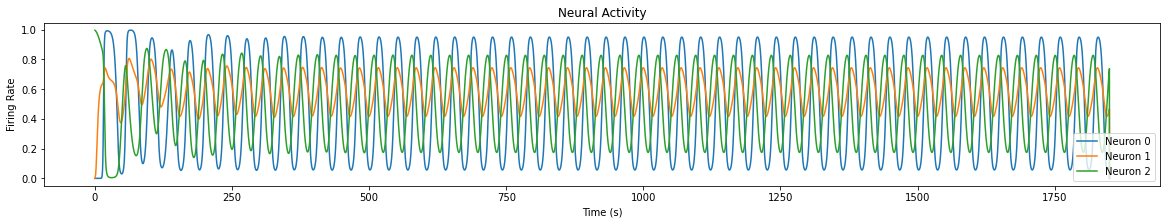

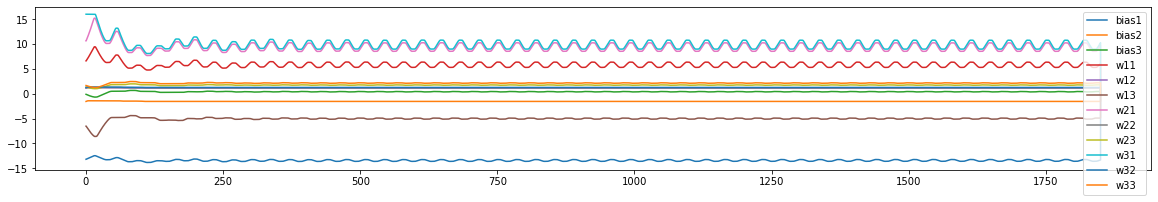

In [29]:
weights = np.array([[6.60946,1.14559,-6.51152],[10.6385,1.19458,1.34445],[16,1.26722,1.663]])
biases = np.array([-13.1741,-1.54257,-0.114027])
timeconstants = np.array([9.42607,2.41159,7.85833])
C2 = CTRNN(3,0.1,duration,1,weights,biases,timeconstants)
C2.setFacilitationFunctionParams(np.array([.25,.25,.25]),np.array([.75,.75,.75]),np.array([-4,-4,-4]))
C2.setAdaptiveTimeConstants(np.array([40,40,40]),np.array([20,20,20]))
C2.initializeState(invsigmoid(np.array([5.03977e-14,7.88983e-3,9.95847e-1])))
for i in range(18499):
    C2.ctrnnstep(1)
print(C2.Weights)
print(C2.Biases)
C2.plot()
plt.show()
for i in range(3):
    plt.plot(C2.time,C2.bias_record[i],label = 'bias%s'%(i+1))
for i in range(3):
    for j in range(3):
        plt.plot(C2.time,C2.weight_record[i,j], label = 'w%s%s'%((i+1),(j+1)))
plt.legend()